# Automatic Seismic to Well Tie

#### Import packages

In [22]:
import numpy as np
import pandas as pd

from pathlib import Path
import yaml

from wtie import grid, autotie, viz
from wtie.utils.datasets import tutorial

from pprint import pprint

import matplotlib.pyplot as plt

# uncomment if your browser supports it
#%matplotlib notebook 

### Import data


In this tutorial we work on data from the Well *Torosa1* of the open [Poseidon](https://terranubis.com/datainfo/NW-Shelf-Australia-Poseidon-3D) dataset. Data is saved in the folder **data/tutorial**.

In [2]:
# data path
folder = Path('../data/tutorial')
assert folder.exists()

inputs = tutorial.load_poseidon_data(folder, well='torosa1')

### Load pretrained network to extract the wavelet

In [3]:
# neural network's weights
model_state_dict = folder / 'trained_net_state_dict.pt'
assert model_state_dict.is_file()

# network training paramters
with open(folder / 'network_parameters.yaml', 'r') as yaml_file:
    training_parameters = yaml.load(yaml_file, Loader=yaml.Loader)
    
wavelet_extractor = tutorial.load_wavelet_extractor(training_parameters, model_state_dict)

Loading network parameters from ../data/tutorial/trained_net_state_dict.pt


### Load synthetic modeling tool

In [4]:
modeler = tutorial.get_modeling_tool()

### Parameters for the search

In [5]:
print(autotie.tie_v1.__doc__)


    Utility to perform automatic (prestack) seismic to well tie. This version 1
    serves as a base recipe. Feel free to implement your own recipe using the
    various tools of the package.

    Parameters
    ----------
    inputs : _tie.InputSet
        Necessary inputs for the well tie.
    wavelet_extractor : wtie.learning.model.BaseEvaluator
        Object to extract a wavelet using the provided neural network.
    modeler : wtie.modeling.modeling.ModelingCallable
        Synthetic modeling tool.
    wavelet_scaling_params : dict
        Parameters for the search of the optimal absolute wavelet sacle.
        3 parameters: 'wavelet_min_scale' and 'wavelet_max_scale' are the search
        bounds. 'num_iters' (optional) is the total number of iterations for the
        search.
    search_space : dict, optional
        Bounds of the search space. See `get_default_search_space_v1`.
    search_params : dict, optional
        Dict with 3 parameters for the Bayesian search. 'num_iter

#### Define the tie parameters search space (optional)

So far, supported parameters correspond to the log filtering and depth to time table bulk shift. See the `tie.get_default_search_space_v1` docstring.

In [6]:
print(autotie.get_default_search_space_v1.__doc__)


    Search space of version 1 is composed of 4 parameters:
        - "logs_median_size" : size (in number of samples) of the median filter window.
        - "logs_median_threshold" : threshold value with respect to the logs standard deviation.
        - "logs_std" : standard deviation of the gaussian smoothing filter.
        - "table_t_shift" : bulk shift in seconds of the depth-time relation table.

    Parameters are defined following the [Ax](https://github.com/facebook/Ax)
    documentation.


In [7]:

# Logs processing
median_length_choice = dict(name="logs_median_size", type="choice",
                  values=[i for i in range(11,63,2)], value_type="int")

median_th_choice = dict(name="logs_median_threshold", type="range",
                  bounds=[0.1, 5.5], value_type="float")

std_choice = dict(name="logs_std", type="range",
                  bounds=[0.5, 5.5], value_type="float")


# bulk shift in seconds
table_t_shift_choice = dict(name="table_t_shift", type="range",
                  bounds=[-0.012, 0.012], value_type="float")


search_space = [median_length_choice,
                median_th_choice,
                std_choice,
                table_t_shift_choice
                ]

#### Bayesian search parameters (optional)

In [8]:
search_params = dict(num_iters=80, similarity_std=0.02)

#### Wavelet absolute amplitude search params

In [9]:
wavelet_scaling_params = dict(wavelet_min_scale=50000, wavelet_max_scale=500000, num_iters=60)

### Optimization

In [10]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


outputs = autotie.tie_v1(inputs,
                         wavelet_extractor,
                         modeler,
                         wavelet_scaling_params,
                         search_params=search_params,
                         search_space=search_space,
                         stretch_and_squeeze_params=None) 

Search for optimal parameters


  0%|          | 0/80 [00:00<?, ?it/s][WARNING 10-13 00:22:45] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:22:45] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `experiment` to be of type typing.Union[ax.core.experiment.Experiment, NoneType]. Got Experiment(auto well tie) (type: <class '

upper
[3552.82941109 3602.21071297 3882.96726725 3629.82569816 3382.83822138
 3505.75836186 3579.86258172 3580.45104504 3547.01049704 3496.18778311
 3471.47989481 3478.44338097 3415.42591853 3455.9101913  3564.61509451
 4002.60723407 4532.27513421 4365.18270179 4504.46430073 4835.04101449
 4608.95021585 4312.84526957 4089.35306757 4089.80865054 4106.82381816
 4066.29493864 3954.56689974 3810.9835973  3939.53584604 4024.30013123
 3846.18988794 3838.13714829 4055.62647994 4115.90125947 4173.81180749
 4085.99460811 3796.09261636 3817.10014608 3797.82126466 3797.01156059
 3867.69207099 3566.78091774 3540.01275108 3715.00620521 3484.97938241
 3433.39057153 3513.09826251 3269.67654016 3190.79186383 3262.53212207
 3233.08204408 3166.87688569 3147.61075623 3407.30003402 3564.37684785
 3560.90498917 3652.88260184 3647.99773682 3676.73255185 3672.46241586
 3677.93141855 3721.50985421 3630.615076   3644.18358047 3618.11543307
 3520.0302351  3553.1885677  3582.88943329 3546.45794435 3550.74087502


  1%|▏         | 1/80 [00:01<01:46,  1.35s/it][WARNING 10-13 00:22:46] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:46] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:46] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 1 (type: <class 'int'>).
[WARNING 10-13 00:22:46] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:46] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndar

upper
[3589.22792163 3626.58075618 3641.82026301 3515.43462074 3440.66268225
 3496.44369824 3555.17193402 3569.23416265 3542.03339331 3504.59412438
 3479.38286662 3462.32918069 3444.86283675 3489.8063393  3647.72088848
 3981.91569236 4372.06752714 4600.68761123 4750.89512532 4770.61332746
 4605.05422803 4380.10349095 4179.38073823 4104.4149976  4092.70703434
 4048.37985573 3948.76452015 3877.28060368 3930.31963021 3960.42610998
 3889.58297278 3896.21802897 4018.74554403 4112.53193388 4138.26697698
 4040.21881419 3870.2691478  3810.35292385 3795.69160521 3766.00874485
 3709.04576462 3602.89724472 3589.30552179 3610.611365   3522.38020049
 3449.03148984 3409.25003096 3307.95940243 3238.22817989 3236.15523786
 3219.19052816 3193.62658006 3237.87972242 3378.7394087  3512.42810171
 3582.16898431 3628.26959659 3654.66243022 3668.86323906 3674.92757918
 3686.39547576 3687.75462343 3655.72738686 3633.90884373 3600.74396083
 3555.33373568 3553.9744591  3565.31920555 3558.20375808 3570.89064802


  4%|▍         | 3/80 [00:01<00:34,  2.20it/s][WARNING 10-13 00:22:47] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:47] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:47] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 3 (type: <class 'int'>).
[WARNING 10-13 00:22:47] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:47] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndar

upper
[3552.079764   3615.83245296 3740.45511023 3477.33306615 3383.27245118
 3509.50467541 3573.34417984 3588.27050684 3540.86090053 3500.6528739
 3469.59197761 3478.89133465 3415.85980409 3453.82824253 3564.5177193
 4000.44910241 4536.82440862 4362.92870304 4503.2977144  4838.23361724
 4608.1421337  4313.20444589 4087.92147409 4090.05560594 4107.01172459
 4066.37480229 3955.17268482 3809.27195952 3939.80363668 4025.78979496
 3845.17141654 3836.84037093 4056.68368193 4115.67884431 4174.3057635
 4087.28137536 3793.98428752 3817.65912702 3797.78991238 3796.05831057
 3870.47031675 3565.15932996 3538.3579156  3718.091742   3483.54448646
 3432.27068347 3515.85002174 3268.12878541 3189.80664082 3263.37583462
 3233.21717635 3166.85025088 3145.04961202 3408.28252079 3565.73995769
 3559.76506564 3653.83604303 3647.49471392 3677.00287319 3672.44840132
 3677.42959069 3722.60496955 3629.66972095 3644.50687466 3618.6179405
 3519.03614909 3553.28724864 3583.29730984 3546.20340428 3550.1719326
 3626

[WARNING 10-13 00:22:47] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:47] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:47] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 5 (type: <class 'int'>).
[WARNING 10-13 00:22:47] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:47] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneTy

upper
[3574.95353838 3627.36096447 3672.55221709 3504.10719697 3416.62366778
 3498.73055194 3563.69062849 3575.85992798 3543.36977128 3501.27784515
 3478.0054111  3464.72106876 3434.42437072 3472.3788855  3623.31613569
 4016.77613618 4432.36333939 4550.44478561 4707.53472899 4789.8985733
 4599.11495205 4326.58610002 4115.90223787 4093.61357992 4097.18508219
 4056.54800308 3948.12678817 3852.89374209 3935.0576145  3980.98860569
 3874.85818453 3874.72596971 4028.71183181 4117.69699634 4153.38202604
 4054.68908966 3847.01991758 3808.2294167  3800.66702169 3811.03205091
 3802.31328489 3612.78489577 3578.03479665 3641.30173297 3517.534693
 3458.13117508 3449.73817395 3302.68605227 3221.10240974 3242.57613434
 3224.48036461 3178.77866733 3209.42880637 3385.53065353 3529.45452814
 3580.52493363 3633.75864013 3655.00324304 3670.70935655 3673.60825246
 3685.89929844 3696.72794234 3650.06265717 3636.63510786 3605.3812213
 3544.27424537 3552.32435155 3570.89006439 3553.76315553 3564.30969772
 361

  9%|▉         | 7/80 [00:02<00:18,  4.05it/s][WARNING 10-13 00:22:47] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:47] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:47] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 7 (type: <class 'int'>).
[WARNING 10-13 00:22:47] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:47] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndar

upper
[3574.52494353 3627.330085   3673.3106109  3503.63577359 3416.34284784
 3498.49366654 3564.07277113 3575.86641545 3543.24552638 3501.50100291
 3477.41174195 3465.7073     3433.33601297 3472.83716646 3621.98485556
 4016.60202162 4430.95882289 4509.87749154 4664.62252993 4786.39066948
 4599.70762842 4325.60652282 4116.4399335  4092.63637334 4098.16000956
 4056.24758008 3948.33571788 3852.3031725  3934.93633837 3981.7446906
 3874.17737193 3874.45915427 4028.82401373 4117.73992408 4153.72239966
 4054.89569119 3846.5393912  3808.1194514  3800.62899255 3810.94579647
 3802.93779364 3612.23499269 3577.56873478 3642.05978415 3517.17721969
 3457.8671876  3450.33720089 3302.33343165 3220.67929667 3242.72194454
 3224.5872186  3178.4720554  3208.71474085 3385.70190423 3529.8167644
 3580.38336101 3633.88017352 3654.94956324 3670.72972802 3673.547687
 3685.82803471 3696.93219013 3649.86189894 3636.67420926 3605.47766423
 3543.9738243  3552.2718945  3570.99904471 3553.63221528 3564.12394769
 361

 10%|█         | 8/80 [00:02<00:17,  4.22it/s][WARNING 10-13 00:22:48] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:48] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:48] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 8 (type: <class 'int'>).
[WARNING 10-13 00:22:48] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:48] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndar

upper
[3585.37731497 3627.25577194 3649.1446817  3512.72370329 3434.29446629
 3496.50435921 3557.66552829 3570.81750652 3542.52107507 3503.48064939
 3479.04610388 3462.94399363 3441.60576475 3486.67697518 3650.48671143
 4016.91953264 4402.08476515 4556.96015103 4703.23970726 4769.91887594
 4594.33938804 4330.07620083 4132.25443235 4094.86451443 4093.99678715
 4050.29590245 3948.5689769  3870.8154349  3931.84907795 3965.30486649
 3885.91137255 3890.59131375 4020.86103711 4114.14140122 4142.35480311
 4043.6480754  3864.53143361 3809.70499908 3802.529544   3810.68373922
 3781.73949556 3630.36657494 3590.0459038  3618.67161834 3525.92882172
 3464.75885934 3431.49651759 3311.5542469  3234.53742502 3237.36618741
 3220.357197   3189.27783554 3230.88811874 3380.03222981 3516.56938922
 3582.37451891 3629.37885242 3654.95399915 3669.21969664 3674.53902252
 3686.4740717  3689.71346438 3654.59895448 3634.48439278 3601.67488743
 3552.64730204 3553.37377497 3566.55469809 3557.02674471 3569.22142978


 11%|█▏        | 9/80 [00:02<00:15,  4.46it/s][WARNING 10-13 00:22:48] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:48] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:48] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 9 (type: <class 'int'>).
[WARNING 10-13 00:22:48] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:48] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndar

upper
[3533.99431624 3537.86017612 3532.42379581 3537.73338997 3533.56930031
 3533.96524592 3556.07256027 3508.08510682 3495.77651693 3508.84317102
 3477.11295657 3495.52556556 3484.329621   3440.05945334 3541.60975357
 3773.10679556 4017.89810155 4305.66597939 4540.97526162 4637.13042917
 4525.23083059 4298.98123546 4238.80404462 4191.81324649 4110.38352045
 4066.34206854 3963.30843301 3897.08664387 3917.08831215 3933.35069636
 3917.36317906 3985.47503905 4032.94750792 3982.82511221 4036.32743261
 4029.78508829 3947.69760099 3915.25758343 3788.99821249 3732.30640165
 3727.88205361 3611.30044152 3582.8107911  3603.6278496  3485.02765412
 3370.42129611 3323.27572379 3245.4135139  3230.4427198  3268.35803402
 3267.2317621  3244.25829059 3281.29220664 3467.24586011 3566.48639133
 3565.76163641 3624.59096458 3626.60544233 3650.66147817 3659.43188316
 3654.45617146 3675.28018017 3616.10779062 3618.40214349 3597.59327753
 3536.5747605  3569.37504336 3581.88463966 3573.30508392 3599.86406901


 14%|█▍        | 11/80 [00:03<00:15,  4.39it/s]

upper
[3573.93788408 3613.74140552 3619.23438764 3493.71943777 3444.70336884
 3506.65524217 3559.40863969 3569.17894063 3531.98762795 3501.86604181
 3478.30678379 3461.32492378 3440.08425268 3460.99814763 3609.37182933
 3888.42258391 4287.0521874  4637.23693614 4758.47708411 4739.20265562
 4632.71295116 4373.20454237 4171.65161263 4134.4196053  4082.2777425
 4013.71969347 3932.70995558 3879.21663573 3923.53785279 3938.8217577
 3872.52392888 3893.67059455 4049.28684387 4144.11985978 4142.5861335
 4060.21096989 3885.34601488 3811.10726057 3823.65212309 3811.33485626
 3774.92539425 3650.66875702 3575.63129177 3592.24860352 3518.63107024
 3429.47088909 3369.18516063 3260.65952295 3216.83632899 3242.39886221
 3228.02698687 3206.51623619 3270.17164956 3429.50487108 3536.93634522
 3580.5331798  3634.13204454 3654.77503162 3670.89735687 3673.05520979
 3685.85430552 3697.4142952  3649.49585387 3636.79995506 3605.83096786
 3543.20753349 3552.29043081 3571.17453472 3553.64771331 3563.47653258
 36

[WARNING 10-13 00:22:48] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:48] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:48] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 11 (type: <class 'int'>).
[WARNING 10-13 00:22:48] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:48] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3584.65441129 3627.34015552 3650.45897578 3512.1238009  3433.3577945
 3496.35624129 3558.19647914 3571.03052101 3542.49814899 3503.50912536
 3478.66872673 3463.61932301 3440.59112278 3486.27527836 3648.42645983
 4016.83403437 4398.47745654 4519.2281396  4663.79523589 4764.24933569
 4595.14154632 4329.15593483 4131.96192536 4094.1360142  4094.79384933
 4050.42768138 3948.58043525 3869.75446399 3931.88173926 3966.37481576
 3885.03638273 3889.77854804 4021.16401792 4114.40091581 4143.08908951
 4044.15921998 3863.61251566 3809.44319549 3802.41509813 3810.77788595
 3782.79893427 3629.38834719 3589.33948258 3619.86126313 3525.49617742
 3464.40656656 3432.42144542 3311.06165156 3233.7388545  3237.57968088
 3220.55417238 3188.56490736 3229.6528494  3380.27512183 3517.2781325
 3582.34169252 3629.57274234 3654.96937353 3669.27157998 3674.45674855
 3686.45471559 3690.05509049 3654.36323965 3634.57417753 3601.83520654
 3552.15870634 3553.26569666 3566.76364948 3556.81006379 3568.91626123
 3

 16%|█▋        | 13/80 [00:04<00:18,  3.60it/s][WARNING 10-13 00:22:49] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:49] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:49] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 13 (type: <class 'int'>).
[WARNING 10-13 00:22:49] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:49] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

upper
[3572.30575361 3627.01511528 3679.70065517 3501.60531322 3412.02764526
 3499.86429013 3565.25448472 3577.34330619 3543.64126145 3500.79659259
 3477.84334666 3465.49162269 3432.80520825 3469.15447941 3616.04100009
 4016.6832147  4441.06310757 4548.10237154 4708.70136777 4795.37035392
 4600.28599647 4325.92084502 4111.51659188 4093.79620614 4097.95856226
 4058.3715594  3948.42978999 3847.93232625 3936.06805717 3985.69693823
 3871.87273467 3870.36910468 4031.47262999 4118.32505504 4156.26748286
 4058.18618333 3841.76915411 3808.5712136  3800.30810342 3810.58992556
 3808.96745212 3607.63165904 3574.4106725  3648.7058157  3514.67026406
 3455.97998843 3455.87923329 3299.84553492 3217.43133789 3244.55304628
 3225.84793416 3176.45007766 3203.10114521 3387.59369115 3533.36666476
 3579.46206239 3635.42162008 3654.86860695 3671.34320021 3673.49464736
 3685.59060765 3699.15560221 3648.52960323 3637.45475368 3606.75446932
 3541.84506578 3552.29740356 3572.35495133 3552.97164511 3562.98265302


 18%|█▊        | 14/80 [00:04<00:18,  3.59it/s][WARNING 10-13 00:22:49] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:49] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:49] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 14 (type: <class 'int'>).
[WARNING 10-13 00:22:49] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:49] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

upper
[3545.2492523  3581.1566799  3919.14855125 3633.22333242 3363.88348444
 3511.9920021  3582.95101589 3582.91388299 3547.79932497 3494.24592283
 3469.37302086 3483.0886805  3409.55647666 3452.12378241 3543.72182826
 3995.86540247 4572.46364824 4341.98535745 4496.54033403 4864.88262313
 4606.62724162 4311.29267995 4077.88976658 4092.05620266 4107.79738392
 4069.43893939 3959.45009168 3794.63207048 3941.19276455 4041.98361115
 3835.36572207 3823.00936314 4069.26677777 4112.18348008 4179.58742731
 4101.00920757 3771.7288377  3824.5825379  3797.97674313 3785.13206087
 3900.818671   3550.63099503 3520.38833545 3751.39978825 3468.86271627
 3420.28629701 3546.41893458 3250.99608218 3180.75939687 3272.65643223
 3233.85026878 3168.78273106 3117.6246537  3419.63467888 3580.51934795
 3546.65571023 3665.14957667 3641.49949504 3680.35345757 3672.78827777
 3671.75087409 3734.96241574 3619.38914863 3648.37424119 3624.12338076
 3508.75432042 3554.84244943 3587.58157322 3543.99858192 3544.315788
 3

 19%|█▉        | 15/80 [00:04<00:17,  3.68it/s][WARNING 10-13 00:22:49] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:49] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:49] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 15 (type: <class 'int'>).
[WARNING 10-13 00:22:49] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:49] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

upper
[3531.26996462 3596.9434989  3800.64772636 3464.65083462 3364.30058499
 3526.78287597 3569.41320853 3600.44843596 3540.68188682 3491.49462139
 3477.61230437 3472.27560398 3421.9390634  3438.36546779 3516.01249313
 4006.23005895 4593.5685798  4695.62922592 4867.77522507 4833.12096112
 4651.72481896 4407.24676356 4083.88873592 4122.06610596 4098.65402148
 4071.35131006 3948.39942013 3760.28663715 3944.26408843 4065.87736158
 3825.14421454 3800.10861102 4088.98085121 4131.86604135 4186.79807524
 4117.31025627 3756.48475121 3768.48621335 3748.25638113 3756.34840868
 3883.32382564 3505.28273506 3462.37729719 3758.06154431 3445.05725562
 3343.70038714 3528.04258286 3230.90005558 3170.37498632 3283.5814305
 3233.11538005 3174.51409623 3093.78071934 3444.92145044 3600.40679259
 3525.68034355 3684.11606589 3631.27624863 3685.81853322 3674.678098
 3662.39217073 3755.27723664 3603.35606013 3654.80021341 3632.31228693
 3494.13860397 3558.53352339 3592.67824359 3543.39236829 3534.7671381
 364

 20%|██        | 16/80 [00:04<00:16,  3.78it/s][WARNING 10-13 00:22:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 16 (type: <class 'int'>).
[WARNING 10-13 00:22:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

upper
[3571.59043694 3602.76227184 3609.94244639 3532.50864602 3480.40541385
 3507.89914438 3544.47385033 3555.94907792 3538.36867637 3505.0391507
 3475.09745862 3449.70616254 3438.31450626 3484.2106412  3651.15659015
 3997.27928411 4382.58977311 4625.84028133 4755.83667428 4756.71442696
 4589.91374848 4327.95258505 4137.41363723 4106.8981525  4101.77555728
 4042.24860036 3963.64025386 3938.53245359 3971.76849946 3945.79518788
 3881.49630464 3907.10946177 4027.47255894 4130.01635529 4126.59584931
 4019.31384079 3879.16858769 3797.75436839 3768.09115684 3722.52927439
 3641.21518903 3573.64946613 3576.29308651 3582.01506321 3519.51975802
 3443.59642764 3378.50175414 3306.61893072 3261.76719369 3244.08249606
 3223.44621418 3225.86280962 3295.97700349 3417.75479241 3519.91889096
 3575.6812274  3615.5588292  3648.59934342 3669.15441702 3681.42866118
 3684.88665405 3668.51207104 3637.94858131 3613.78029743 3587.28780161
 3559.97098077 3551.73579373 3556.64336843 3569.64612178 3594.98398165
 

 21%|██▏       | 17/80 [00:05<00:16,  3.77it/s][WARNING 10-13 00:22:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 17 (type: <class 'int'>).
[WARNING 10-13 00:22:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

upper
[3565.46307578 3604.8714257  3617.61122352 3530.0945886  3473.56889745
 3507.55985331 3546.58695821 3557.49622246 3536.78886017 3509.79019917
 3490.35599142 3465.78898181 3448.22341949 3491.24156426 3689.55691604
 4062.5779636  4420.10093085 4625.39888635 4733.26988891 4728.82543893
 4565.11654039 4306.42020131 4131.22239222 4109.7498508  4104.7546562
 4044.93878442 3959.20790051 3934.19980532 3976.36544343 3949.12427439
 3874.79647935 3899.84711853 4027.83885172 4132.72151666 4131.54147014
 4024.45853404 3876.60985389 3794.04995956 3769.59786113 3725.88392245
 3640.50970679 3567.62356602 3576.00012185 3587.16364827 3509.09199356
 3403.85703516 3326.37831448 3270.75877019 3248.34647521 3244.29464231
 3221.31303086 3211.3453936  3284.76083548 3420.53727745 3523.40158934
 3569.43992335 3603.95730038 3640.26942542 3666.9729295  3681.9213979
 3686.7877464  3672.8689135  3640.78453414 3610.34225726 3581.51678819
 3557.56742516 3548.71184686 3550.98244732 3569.45374139 3601.75158857
 3

 22%|██▎       | 18/80 [00:05<00:17,  3.64it/s]

upper
[3524.95394855 3532.12282479 3540.04429254 3539.40768718 3536.42446418
 3537.71877117 3538.77518024 3536.63395769 3524.15319683 3503.62577776
 3482.32342971 3471.84347368 3476.94586509 3517.70073223 3640.91637349
 3834.42997768 4148.43827213 4524.70841143 4681.89634572 4657.83037344
 4572.82633173 4378.84213553 4223.23599516 4159.88641356 4092.14946694
 4017.53734084 3953.0230882  3913.96071404 3895.58134879 3902.06554133
 3930.22494407 3961.60078904 4016.98977248 4079.47646774 4090.95610555
 4042.346401   3967.59248767 3889.22886381 3816.79752964 3760.69506474
 3711.73943205 3660.80514235 3614.09338506 3573.77417274 3524.9850283
 3443.56290286 3345.81362887 3275.54590071 3244.98739736 3234.21458992
 3231.18508422 3255.4033486  3322.05687959 3416.01999181 3507.43858304
 3571.71841019 3611.31120417 3643.01117708 3670.40898533 3685.95115255
 3685.9226875  3666.17075504 3633.91183715 3607.77164286 3581.6328439
 3557.53087282 3552.87642629 3563.76379743 3584.95303627 3610.59296198
 3

[WARNING 10-13 00:22:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 18 (type: <class 'int'>).
[WARNING 10-13 00:22:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3542.4300879  3600.89339268 3786.75591609 3464.05812969 3368.3557435
 3521.63251061 3572.96198768 3596.60572855 3540.78466071 3495.79276711
 3471.22315504 3478.95749231 3412.50226121 3445.7783031  3526.70826254
 4005.99973031 4564.49348102 4444.55580353 4674.19439868 4870.13908074
 4600.76655194 4321.67688619 4057.69869224 4105.52025985 4099.3820284
 4075.72883896 3962.75632288 3781.85274977 3945.49350806 4052.34099021
 3830.4554056  3809.76921064 4080.94568054 4109.26308082 4182.07251211
 4114.39275717 3751.40872622 3831.55182698 3799.48833289 3772.99467885
 3929.70821357 3543.29769002 3503.52142466 3780.58212374 3457.29630757
 3410.56604386 3574.71795896 3234.73816892 3174.7201064  3280.60033832
 3232.98426258 3173.18715383 3093.18155266 3430.88650608 3593.5740507
 3533.63409904 3676.40838786 3635.05009936 3683.6692825  3673.5063602
 3666.14525703 3746.45226649 3609.88655018 3652.06086493 3628.81742031
 3499.92430166 3556.54534449 3590.9800928  3542.48849999 3539.1656572
 3636

 25%|██▌       | 20/80 [00:05<00:16,  3.63it/s]

upper
[3541.72593217 3606.1575411  3751.99592158 3423.00527025 3374.31052462
 3523.49992486 3569.23352982 3604.26672081 3534.40325841 3502.60159028
 3467.25197582 3479.97604406 3416.282238   3434.55739231 3544.25959346
 3892.41684621 4468.88613051 4582.10718359 4747.88490116 4836.16998133
 4610.75970646 4388.15184653 4109.0601309  4092.44826165 4102.85949104
 4078.31944478 3960.23411868 3783.93088716 3941.03980518 4061.3288077
 3825.55660146 3807.92580159 4084.39325979 4108.20611703 4184.78468603
 4116.08055775 3750.49970297 3825.10906395 3816.12252853 3733.91057805
 3855.94453669 3560.53825223 3496.65323796 3763.50860205 3477.75448962
 3340.17658969 3512.18285533 3241.40698661 3169.80703229 3283.57093062
 3234.09688843 3173.10162669 3101.98686553 3439.37485529 3596.82835242
 3530.33003684 3679.89007755 3633.87027085 3684.43324785 3674.62746395
 3664.37404786 3750.61263307 3607.31714751 3653.27424098 3630.99532618
 3497.20544689 3557.57129847 3592.43604845 3542.31956069 3537.94266021
 

[WARNING 10-13 00:22:51] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:51] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:51] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 20 (type: <class 'int'>).
[WARNING 10-13 00:22:51] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:51] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3536.58322426 3597.15805313 3797.64051995 3463.16900215 3365.95699223
 3524.6222591  3571.77278749 3599.0317833  3540.61240536 3494.20462112
 3473.00734034 3476.85569044 3414.07322445 3442.14868824 3520.60272699
 4009.67800705 4562.09827726 4490.14095824 4731.38789659 4863.8164702
 4602.82954623 4322.51952971 4048.128281   4111.23939143 4095.8325485
 4078.77363446 3963.93022579 3775.75028416 3946.89572063 4059.00246776
 3827.33672482 3802.69284289 4086.82294041 4107.13618502 4183.49219199
 4121.38803915 3740.6759481  3834.77953284 3800.83085379 3764.6418951
 3946.30720929 3542.96069095 3492.66610461 3795.81446218 3452.36187206
 3407.30379533 3590.67476429 3224.69292178 3172.27735819 3283.94508748
 3231.66459157 3176.30521275 3079.86504566 3437.77984482 3600.35898782
 3526.14629711 3682.8796506  3631.06216177 3685.56986771 3673.89316796
 3662.99751564 3752.78184985 3604.55201303 3654.01687621 3631.14883269
 3495.28650447 3557.43739205 3592.66255047 3541.81964092 3536.34092996
 36

 28%|██▊       | 22/80 [00:06<00:16,  3.55it/s]

upper
[3543.41619367 3600.74154942 3786.50651994 3465.48252108 3366.54303663
 3524.21393523 3571.01648563 3597.83675024 3541.60004026 3493.38540316
 3476.14372299 3471.95614671 3420.2199191  3439.38587317 3529.66674528
 4011.63695621 4541.37531091 4572.74105204 4790.47118489 4843.37191748
 4610.2061159  4321.50989163 4053.41852924 4112.084452   4092.6594165
 4080.98590883 3959.67298509 3783.46756    3946.05736672 4050.79726918
 3832.89757517 3807.935115   4082.52119195 4108.83956599 4182.13133924
 4115.13282732 3750.86974006 3832.46313288 3799.13387149 3773.48084602
 3929.78444387 3543.28917523 3504.07654114 3780.36513449 3457.72410174
 3410.69655285 3574.77000091 3235.0710425  3174.82671996 3280.85109947
 3233.10425461 3173.38408235 3093.47594781 3430.99391128 3593.73714551
 3533.84500032 3676.56767169 3635.25315824 3683.84048195 3673.69598612
 3666.34415748 3746.59803323 3610.10575449 3652.23479756 3628.98167665
 3500.14631191 3556.72725895 3591.14644564 3542.68359576 3539.37240912
 

[WARNING 10-13 00:22:51] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:51] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:51] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 22 (type: <class 'int'>).
[WARNING 10-13 00:22:51] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:51] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3533.6329559  3597.01859519 3799.3008547  3462.47383318 3366.83588682
 3523.45744873 3572.42728777 3598.81967282 3539.73317125 3495.5018374
 3470.51984158 3480.72309464 3411.01384946 3444.34034312 3519.76411768
 4006.11359186 4575.81357824 4436.39982455 4678.53526922 4875.91797452
 4598.38904779 4321.45414967 4047.75293835 4108.38792105 4099.83115408
 4076.07436067 3965.72652435 3774.0375974  3946.30719245 4061.50527243
 3825.63864791 3802.21476785 4086.62174937 4107.12387838 4184.21069538
 4122.00253303 3739.42622372 3834.76162442 3801.12766617 3763.3633837
 3948.6223204  3543.03500823 3491.07855133 3797.87562874 3451.71545548
 3407.59008765 3592.65135015 3222.75160694 3172.02555606 3284.04306751
 3231.24825521 3176.66684403 3077.94895299 3438.82624636 3601.19044539
 3525.02999323 3683.79310744 3630.46217637 3685.81641508 3673.87177354
 3662.56412476 3753.68142124 3603.75375439 3654.23032718 3631.41187056
 3494.65585527 3557.49082308 3592.86546839 3541.73297153 3535.94000749
 3

[WARNING 10-13 00:22:52] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:52] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:52] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 23 (type: <class 'int'>).
[WARNING 10-13 00:22:52] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:52] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3547.51344129 3559.05509938 3600.0831734  3579.33729271 3519.7320898
 3526.24398129 3556.96284467 3537.71482517 3520.28941816 3502.42861613
 3476.69400178 3461.93280311 3438.61068141 3432.61710153 3585.2089852
 3804.75126951 4129.53523162 4622.24844843 4659.2496228  4587.52486164
 4670.71550042 4337.26072462 4187.2167702  4202.75677315 4060.16952382
 4059.71565875 3962.01777071 3886.75559845 3964.17091144 3960.09358264
 3889.05379701 3945.61164627 4047.24249057 4002.59289698 4038.37809582
 4055.87535648 3940.69734357 3918.9327051  3839.25240892 3732.83449189
 3750.02185693 3656.93945089 3563.07894413 3617.64652758 3489.32223336
 3368.60389685 3387.298741   3228.90171827 3190.05779066 3267.71940825
 3259.44630285 3236.31257003 3244.8692891  3483.36574764 3573.196615
 3551.47263021 3666.21777046 3636.80265757 3684.38066198 3678.14697233
 3642.69240994 3702.11771261 3612.79698856 3635.83279902 3613.85911322
 3517.28991208 3564.0881705  3584.03189871 3554.60661278 3547.59203588
 364

 31%|███▏      | 25/80 [00:07<00:17,  3.15it/s]

upper
[3590.60286953 3626.10608635 3638.25979414 3516.21064446 3444.00660414
 3495.65212419 3554.36635434 3567.87962839 3541.40485858 3505.1208229
 3478.64297458 3464.11908373 3444.78715552 3496.64238704 3664.20029399
 4014.92686674 4367.40987022 4432.88702957 4548.87143763 4718.62712777
 4592.85112034 4329.56752121 4143.00312703 4094.75155507 4093.3075443
 4046.67631973 3949.36262724 3879.88716929 3929.56743186 3958.34741878
 3890.80877865 3898.82955899 4017.60733055 4110.95165399 4136.04402417
 4038.1898331  3872.59764577 3811.5953148  3803.44611683 3809.05187734
 3772.6416953  3638.39891114 3595.21699325 3609.08770358 3528.66448688
 3467.08291462 3423.98994479 3315.04847107 3241.07277443 3235.49101737
 3218.62879604 3195.40309944 3240.8903362  3377.98222134 3510.20410211
 3581.8123696  3627.47918382 3654.31001352 3668.48730496 3674.87596877
 3686.1275278  3686.63948025 3655.99404535 3633.42401459 3600.1528149
 3556.35956883 3554.0694271  3564.58244951 3558.53891848 3571.4671144
 361

[WARNING 10-13 00:22:53] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:53] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:53] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 25 (type: <class 'int'>).
[WARNING 10-13 00:22:53] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:53] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3515.56999746 3583.43012315 3608.66914572 3450.15859921 3428.95723771
 3510.45033951 3567.33790459 3581.23933126 3526.57461109 3503.43224324
 3475.40197419 3464.55901767 3436.03872096 3433.03940118 3586.20338831
 3875.62254899 4297.35751742 4664.90431405 4773.88305169 4728.14438332
 4625.20606135 4343.6948473  4123.5568403  4121.78531138 4085.76297106
 4065.68463215 3991.84859574 3871.33483703 3936.56286082 3996.86414056
 3870.14787315 3873.03751729 4047.69388167 4107.68770646 4146.68347749
 4074.47244955 3867.71440986 3845.16214913 3834.23072484 3783.78762312
 3740.03204552 3580.54183565 3586.34487313 3664.55176133 3482.13370629
 3385.11253485 3416.02549961 3254.37638867 3192.90656871 3261.47611214
 3232.05107448 3178.4088799  3211.70526399 3439.93185066 3559.28801855
 3564.90985118 3650.49523597 3649.29419254 3676.51251628 3672.09231596
 3679.34570451 3719.55720436 3632.57517474 3643.69934497 3617.53380422
 3521.75004782 3553.316454   3582.12085458 3547.71653935 3551.07164912


[WARNING 10-13 00:22:53] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:53] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:53] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 26 (type: <class 'int'>).
[WARNING 10-13 00:22:53] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:53] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3543.16270528 3585.27441832 3613.57299481 3576.9317133  3520.98253706
 3517.94817536 3543.38591231 3549.76133348 3547.41900207 3501.56114586
 3483.8686376  3458.98369679 3427.19925605 3440.63422787 3552.28807168
 3916.51621603 4311.69123614 4635.33832436 4734.72294186 4643.30157716
 4648.63108951 4385.969203   4094.27053914 4121.4191855  4123.31013286
 4050.24548556 3915.51102882 3872.07417924 3930.79127392 3921.56985039
 3925.56735099 3934.40921951 4049.90872877 4173.27750559 4139.90653121
 4055.89311721 3891.54517891 3820.35525333 3795.02687852 3692.99232271
 3641.90957116 3586.34339354 3581.17666304 3599.82993254 3560.78226553
 3459.63967229 3318.71293272 3242.54744739 3237.42799959 3253.99402711
 3249.37882517 3212.70259708 3251.09237201 3461.33847442 3577.99722691
 3564.95834343 3625.64970496 3657.04999518 3689.40854928 3688.54752045
 3669.662154   3677.48225334 3614.69814337 3618.88844049 3598.00944156
 3523.49342578 3553.82758103 3569.22806391 3565.50531211 3603.57953948


[WARNING 10-13 00:22:53] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:53] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:53] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 27 (type: <class 'int'>).
[WARNING 10-13 00:22:53] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:53] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3548.2476773  3614.58275067 3719.96676058 3436.62787851 3379.11366192
 3516.13503447 3570.64332162 3595.78114161 3538.04019616 3501.55918266
 3470.51133651 3476.07943575 3420.04349857 3442.71678874 3556.5918244
 3903.9812674  4446.12680753 4586.79947539 4746.87954976 4824.21470723
 4604.12292347 4378.03825814 4124.1117934  4090.59539423 4102.82922147
 4074.24814928 3953.82828395 3802.33018268 3938.79154544 4038.96186234
 3838.32958491 3826.36189865 4066.81460375 4113.26354977 4179.90966622
 4095.62133957 3782.12662739 3815.62857511 3810.79985815 3750.19766925
 3781.30979682 3539.67225992 3535.59575963 3731.4902648  3487.85308408
 3362.46200035 3474.97652321 3259.66210596 3182.05980464 3270.31634408
 3235.22638431 3167.09808628 3126.64417617 3415.80516062 3578.04169905
 3549.92138946 3662.64632544 3643.78032424 3679.31232957 3673.57533338
 3673.2061901  3732.33214233 3622.399956   3647.61373011 3623.26365948
 3511.54778929 3554.92366561 3586.78969801 3544.90934879 3546.2157532
 3

[WARNING 10-13 00:22:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 28 (type: <class 'int'>).
[WARNING 10-13 00:22:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3566.92185751 3625.05370124 3695.3193661  3495.65808938 3402.56802276
 3502.7278776  3567.38720206 3580.81718909 3543.23019863 3500.33859444
 3476.91629801 3466.53137676 3430.38878135 3461.1398474  3595.23319324
 3971.82127438 4426.09795628 4598.62605772 4769.17428413 4804.35062585
 4608.53809887 4383.04465088 4148.8468175  4094.54224946 4099.19310723
 4062.37433094 3948.0531084  3838.58936238 3936.3194688  3996.65905918
 3864.43481692 3861.62716881 4037.13833264 4119.17218582 4162.05531371
 4064.86692316 3831.55629981 3807.0054924  3802.35522852 3764.20146895
 3736.68858318 3569.64296209 3569.25144406 3662.10008146 3507.34723951
 3427.50978841 3448.69531228 3290.11727694 3209.30781431 3249.22105017
 3228.08856013 3172.39894185 3188.86605412 3392.16808088 3541.8097812
 3575.74787557 3639.44188287 3653.76499281 3672.60274754 3673.12799115
 3684.17961296 3704.61845573 3644.43157725 3639.12266573 3609.63288206
 3536.19675834 3552.2364748  3575.25540012 3551.11303991 3559.80876766
 

[WARNING 10-13 00:22:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 29 (type: <class 'int'>).
[WARNING 10-13 00:22:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3572.55507866 3626.99014543 3678.50581914 3501.96783671 3412.37036125
 3499.71207927 3564.8645019  3576.96890549 3543.74063053 3500.31314461
 3478.07136803 3464.58470063 3433.38748181 3468.94467974 3611.82361399
 4023.56316242 4476.8266294  4606.47694116 4734.30604722 4782.55314714
 4628.40328008 4393.57159802 4156.74808543 4131.81792181 4140.96804074
 4066.68880025 3909.38245847 3803.13799267 3925.24440005 3987.14802685
 3871.54083592 3875.49352188 4067.63413662 4172.32018058 4155.82048014
 4046.99213058 3836.91807117 3769.20547314 3780.65837947 3764.57243422
 3700.12048755 3528.90271586 3534.70202448 3619.77492262 3495.61607361
 3423.55387335 3420.10939844 3290.15106977 3218.67074551 3243.43812964
 3226.26219337 3179.86939397 3212.10009383 3393.01574993 3533.32225629
 3579.65128738 3634.97495308 3654.81542696 3671.1045627  3673.36030786
 3685.51818923 3698.69868716 3648.62909679 3637.20386195 3606.49028048
 3541.97405645 3552.3026764  3571.8295047  3553.18361264 3562.87312884


[WARNING 10-13 00:22:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 30 (type: <class 'int'>).
[WARNING 10-13 00:22:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3544.16482946 3602.9842558  3780.1061551  3466.74275896 3367.98641568
 3522.6435809  3570.98719324 3596.87214298 3541.22861746 3494.17223966
 3475.84949528 3471.51703282 3421.36110254 3439.20219286 3535.44014477
 4009.82042897 4537.75173807 4574.49707471 4787.90865477 4844.11184378
 4602.39804758 4352.55137383 4090.74299689 4102.96889262 4096.48217349
 4078.89613328 3957.80385026 3788.83099452 3941.99007979 4050.86716105
 3830.28898947 3816.47999193 4075.19239335 4111.64685644 4183.48078445
 4102.85820788 3776.04329335 3761.58855141 3733.39163608 3771.91751682
 3849.1246372  3533.22010271 3521.11147712 3758.99516581 3475.07467461
 3379.44488771 3538.89948865 3245.02954445 3173.54465553 3280.49602258
 3232.06271979 3172.38324146 3101.22227464 3426.56212492 3590.76750204
 3536.79622787 3673.76187437 3636.90433504 3682.69625483 3673.70695466
 3667.61026429 3743.37321566 3612.71571692 3651.16256724 3627.5093335
 3502.67673914 3556.28048309 3589.92542725 3543.16360538 3540.8518518
 3

[WARNING 10-13 00:22:55] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:55] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:55] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 31 (type: <class 'int'>).
[WARNING 10-13 00:22:55] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:55] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3546.99273499 3584.51537632 3611.75262518 3576.27062292 3522.49879318
 3519.34809051 3542.44405981 3549.80007767 3545.68917047 3502.42599026
 3483.59311345 3458.72303324 3429.10830507 3442.8001348  3560.54869433
 3916.00232254 4308.68307749 4632.41254128 4730.14563617 4646.50303044
 4642.78998086 4384.45841881 4101.52535329 4120.36340719 4121.82052493
 4048.67660734 3917.984782   3874.68098274 3928.89822738 3922.22459471
 3925.0588052  3937.32335628 4050.20014599 4169.13047637 4139.64806348
 4053.41435893 3894.47811092 3821.49759357 3792.37144851 3694.8499089
 3641.34882745 3587.92705075 3581.65870648 3597.96678628 3558.60836141
 3458.18815128 3321.08790625 3244.49716198 3237.97778915 3253.56915049
 3247.74985369 3214.90067368 3258.75515243 3457.28256012 3572.61883557
 3568.70712216 3623.92004075 3657.58782718 3688.37898769 3687.55215532
 3671.08465983 3674.55939508 3617.36992634 3617.89899782 3595.89535134
 3527.39535571 3552.88800292 3568.50489433 3566.61754731 3603.61770619
 

[WARNING 10-13 00:22:55] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:55] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:55] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 32 (type: <class 'int'>).
[WARNING 10-13 00:22:55] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:55] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3575.0357507  3642.89289038 3796.09229331 3628.37708854 3440.86244683
 3497.05340566 3567.09873995 3573.39071751 3544.40020899 3500.96264296
 3476.11972727 3467.97939973 3431.41640956 3474.1025115  3621.48266112
 4014.39585275 4432.7580046  4425.79440631 4548.69309578 4766.98672742
 4603.93191638 4321.57995197 4119.72054617 4090.00322764 4100.23093079
 4055.7766143  3948.29518563 3852.50726197 3934.10780675 3982.93904168
 3873.20674387 3874.63206577 4028.86490771 4117.56676388 4154.20572607
 4054.70705637 3846.50798596 3807.94697246 3800.62026336 3810.96631274
 3803.16791935 3612.04920966 3577.23810386 3642.51128304 3516.97976156
 3457.70452309 3450.69644158 3302.10677186 3220.48480511 3242.78452918
 3224.6485048  3178.31773456 3208.32096859 3385.80881984 3530.00025893
 3580.31387959 3633.9451643  3654.91898272 3670.74627519 3673.51147703
 3685.79447576 3697.04040038 3649.7556722  3636.69698433 3605.52890647
 3543.81590309 3552.24369815 3571.05926314 3553.56306995 3564.02544277


[WARNING 10-13 00:22:56] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:56] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:56] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 33 (type: <class 'int'>).
[WARNING 10-13 00:22:56] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:56] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3581.85320596 3649.38025918 3776.70834111 3627.44796086 3455.7647302
 3497.21147919 3563.09510283 3571.26290055 3543.50681044 3502.28116369
 3476.87186905 3466.43911132 3435.57413659 3481.31448578 3636.33441791
 4015.28757044 4408.46982232 4419.95428232 4538.48138948 4748.43240573
 4601.00261176 4323.8776055  4128.16472149 4090.91988634 4098.19618319
 4052.53073314 3948.17549184 3862.52908442 3932.40003443 3973.75420245
 3879.53507278 3883.41264367 4024.09562514 4115.95151457 4148.2041276
 4048.30323622 3856.61246562 3808.24588916 3801.57486845 3811.26275849
 3790.96709078 3622.16195301 3584.26099677 3628.97297419 3522.18495889
 3461.72635953 3439.66808571 3307.42137165 3228.02103533 3239.48728756
 3222.17375445 3183.78776816 3220.66556285 3382.34595298 3522.58594836
 3581.84770958 3631.21363995 3655.05713505 3669.79511711 3673.97852765
 3686.28576155 3692.79318507 3652.56946214 3635.37399755 3603.22430342
 3548.64015536 3552.67366519 3568.46452382 3555.35536275 3566.79521457
 3

[WARNING 10-13 00:22:56] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:56] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:56] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 34 (type: <class 'int'>).
[WARNING 10-13 00:22:56] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:56] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3586.71525212 3618.47894283 3617.20772349 3489.18624092 3431.64714144
 3495.82575295 3555.59688048 3570.49763877 3541.76341015 3505.24264499
 3479.02486119 3462.7722823  3444.14079183 3485.4556904  3630.2945986
 3929.6862119  4320.98966848 4576.70206807 4726.75296091 4754.98579012
 4598.98136888 4372.68534829 4177.19949902 4103.68991185 4093.02849982
 4049.60013541 3948.22164188 3875.80342282 3930.41290137 3962.35806414
 3888.31986621 3894.49093197 4019.57379938 4113.33288901 4139.81803205
 4041.47240576 3868.58155888 3809.56515122 3789.57672195 3736.30154235
 3671.7896519  3585.38041805 3582.25320645 3604.89938821 3512.46602807
 3426.3970513  3387.3705487  3298.10344217 3235.66737109 3236.50731514
 3220.44970595 3196.01703218 3242.46198287 3384.46319022 3515.40649118
 3582.42891474 3628.74811102 3654.82646107 3669.04623703 3674.87336063
 3686.50014852 3688.46783687 3655.46253446 3634.17782261 3601.11356655
 3554.55495054 3553.85516898 3565.79026474 3557.90737068 3570.43192362
 

[WARNING 10-13 00:22:56] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:56] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:56] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 35 (type: <class 'int'>).
[WARNING 10-13 00:22:56] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:56] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3545.46778599 3608.28777758 3765.98961607 3469.78859368 3373.03284212
 3517.03436247 3573.27125091 3592.60909029 3541.76519179 3496.35388036
 3472.45005484 3476.70263999 3415.64537605 3448.06588944 3541.2777405
 4007.89858288 4542.7300963  4458.26878658 4669.56859711 4856.40684859
 4602.83557694 4320.52569546 4066.94886506 4101.56293324 4100.45079292
 4073.16094792 3958.59203461 3793.24792191 3943.66324765 4039.52204053
 3837.7801566  3820.83838393 4070.3674806  4112.3651883  4178.85784104
 4102.56810413 3770.08114741 3825.48766682 3797.76709443 3784.69728845
 3902.11140311 3549.90575077 3520.19624498 3752.21052467 3468.55419233
 3419.96442001 3547.30776899 3250.60683766 3180.4124029  3273.0550531
 3233.82409298 3168.91651127 3116.83039976 3419.98033278 3581.04594429
 3546.21050438 3665.56368542 3641.31503782 3680.47527941 3672.84771691
 3671.56868643 3735.39163602 3619.07955066 3648.52288693 3624.31798215
 3508.4585088  3554.92719453 3587.72464255 3543.96486706 3544.15859167
 3

[WARNING 10-13 00:22:57] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:57] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:57] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 36 (type: <class 'int'>).
[WARNING 10-13 00:22:57] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:57] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3541.03208302 3560.81987301 3951.21548128 3642.49867373 3350.65025233
 3517.24778547 3585.29441048 3584.78242791 3548.90905077 3492.59062453
 3467.44451953 3487.2756118  3403.84517951 3450.5991957  3526.20254069
 3990.63615935 4606.93288344 4318.107504   4495.84450064 4893.17134928
 4601.34420821 4312.41045333 4068.03067399 4094.99493006 4108.22252936
 4071.27166439 3965.29468916 3780.44870182 3943.2329299  4058.4285199
 3825.67768113 3809.86576884 4081.99903477 4108.40008602 4183.55356017
 4115.47444137 3748.85059064 3831.82739665 3800.41658818 3770.17175208
 3935.29954401 3543.36583563 3499.25402019 3786.5715919  3455.13023161
 3408.96882738 3580.57576768 3231.09772911 3173.93459259 3281.84013612
 3232.6899074  3174.26419502 3088.28154405 3433.3505457  3596.00670265
 3530.97415228 3678.68508561 3633.62628148 3684.34593407 3673.61983455
 3665.00200736 3748.70666644 3607.9554575  3652.76702761 3629.66893128
 3498.19870747 3556.85691214 3591.5893105  3542.20110596 3538.1174126
 3

[WARNING 10-13 00:22:57] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:57] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:57] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 37 (type: <class 'int'>).
[WARNING 10-13 00:22:57] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:57] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3544.4766492  3606.60897285 3770.9177102  3468.24075371 3371.73010248
 3518.12907836 3573.23939458 3593.51498215 3541.50902311 3496.17159795
 3472.12616141 3477.25221296 3414.87793076 3447.42310518 3537.65203128
 4007.34284161 4548.06220635 4455.07144549 4670.44474915 4859.72885407
 4602.42426143 4320.64453665 4064.6681551  4102.4398396  4100.20647092
 4073.8064609  3959.49278865 3790.45070504 3944.02664789 4042.53515099
 3836.00353098 3818.12616192 4072.87428192 4111.60202571 4179.68230326
 4105.33286304 3765.61494951 3826.92000853 3797.98293654 3782.15924113
 3908.39149597 3547.72395702 3516.42485482 3758.88026438 3465.73102996
 3417.58908523 3553.61597244 3246.96857134 3178.87368874 3274.8673525
 3233.70635091 3169.70472215 3111.25760259 3422.39931594 3583.98342034
 3543.32259161 3668.00306019 3639.90592342 3681.17525849 3672.95367296
 3670.30223745 3737.93436261 3616.92091094 3649.31518348 3625.37221066
 3506.40565603 3555.26744449 3588.49488141 3543.56322856 3542.96149077
 

[WARNING 10-13 00:22:58] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:58] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:58] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 38 (type: <class 'int'>).
[WARNING 10-13 00:22:58] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:58] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3552.49655073 3615.89381326 3740.09599227 3479.02220676 3380.79654857
 3511.96073633 3572.07718486 3588.17464168 3543.18177572 3496.56128194
 3475.44226031 3471.53475099 3421.77408915 3450.50892191 3561.56997054
 4012.74500291 4507.88631144 4521.66595275 4717.07428833 4834.19005398
 4604.91153029 4321.80534745 4077.3623399  4099.67239772 4099.1134992
 4070.68755772 3953.71150163 3808.51094722 3942.08473352 4023.21600121
 3847.8981121  3834.57563451 4057.94476203 4115.79334291 4173.68739015
 4088.75434962 3792.54523577 3818.61576688 3797.50422084 3795.91474789
 3871.42860203 3564.49457438 3538.45391953 3718.56523193 3483.44840496
 3432.09932197 3516.43842839 3268.0060944  3189.53369774 3263.74104654
 3233.27078411 3166.92906934 3144.59870681 3408.52741488 3566.16520019
 3559.55577283 3654.14354769 3647.45945015 3677.13020308 3672.54071767
 3677.38017376 3722.93653231 3629.53347738 3644.65735162 3618.80910233
 3518.89141675 3553.39351362 3583.45928908 3546.22917658 3550.12517507
 

[WARNING 10-13 00:22:58] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:58] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:58] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 39 (type: <class 'int'>).
[WARNING 10-13 00:22:58] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:58] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3534.63143591 3597.35962111 3799.38717815 3463.54636782 3366.30941071
 3524.99907818 3572.00020701 3599.57605983 3540.70403079 3494.53770581
 3473.31609916 3477.77666887 3414.67588659 3442.27594129 3520.6000193
 4010.33510104 4563.62048519 4489.81033282 4731.87696681 4863.91517938
 4602.72035521 4322.33113405 4045.97010524 4112.04386306 4096.86389856
 4078.90302733 3964.71444071 3775.07418483 3947.10059701 4060.90179558
 3827.20867087 3801.82187562 4087.66506931 4107.3346094  4184.47013629
 4122.68466264 3739.60057595 3835.52060414 3801.32786602 3763.97469152
 3948.89876454 3543.3668657  3491.75548541 3798.03419636 3452.27754069
 3407.94563987 3592.93638685 3223.38946699 3172.43086961 3284.51956345
 3231.69134376 3177.0874325  3078.53714496 3439.1628391  3601.57629432
 3525.53865172 3684.1637972  3630.93772955 3686.23014125 3674.31251682
 3663.02503641 3754.04725824 3604.24736232 3654.64992853 3631.82556659
 3495.13697582 3557.92363477 3593.28119314 3542.17383727 3536.40363233
 

[WARNING 10-13 00:22:59] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:59] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:59] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 40 (type: <class 'int'>).
[WARNING 10-13 00:22:59] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:59] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3584.30861076 3627.26285693 3650.94851408 3511.58288968 3433.39291199
 3495.90467518 3558.46371718 3571.12605819 3542.01820198 3504.08528999
 3477.69016718 3465.03848112 3439.47328341 3486.66242417 3647.97735905
 4015.35120351 4393.18132536 4439.38636495 4558.28403164 4739.15574417
 4597.72347593 4326.46235412 4133.80654267 4092.5095027  4096.08753269
 4050.24628637 3948.44168228 3869.69579958 3931.31589198 3967.16934374
 3884.28384888 3889.70473793 4021.16434624 4114.2794712  4143.44276343
 4044.03527657 3863.43509113 3809.21997837 3802.32647478 3810.78149149
 3782.9733662  3629.10976473 3589.00870343 3620.17818614 3525.29622064
 3464.2221656  3432.6541308  3310.82415059 3233.46086731 3237.56582651
 3220.54960004 3188.29728194 3229.21649837 3380.29139625 3517.41221566
 3582.26874662 3629.56326128 3654.90592619 3669.2243934  3674.36366502
 3686.3854105  3690.0885106  3654.22798715 3634.53549236 3601.81615638
 3551.95092729 3553.16795551 3566.7602894  3556.68090671 3568.76117764


[WARNING 10-13 00:22:59] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:22:59] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:22:59] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 41 (type: <class 'int'>).
[WARNING 10-13 00:22:59] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:22:59] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3517.87818459 3533.54162479 3543.79136327 3539.6999867  3535.27157597
 3536.65205421 3538.25501266 3535.87502289 3529.01895316 3509.84544823
 3475.7037196  3469.97941944 3471.39709197 3471.26950541 3592.86025396
 3793.24850389 4131.11534563 4570.58061191 4677.03182517 4633.15032962
 4624.53441778 4391.13847212 4196.55689882 4171.02911654 4108.85424406
 4016.73133421 3950.31928932 3918.90764599 3890.01900986 3894.76432388
 3943.15689482 3978.28665969 4022.11142574 4082.24672657 4096.06903453
 4032.64808743 3960.08310648 3899.09599147 3799.99932417 3735.53500364
 3740.20495197 3719.86773648 3640.58862924 3572.60822694 3510.25676905
 3411.91825487 3325.35845519 3260.90604901 3238.51836634 3238.28713632
 3223.63471226 3232.06326141 3302.76148044 3451.10231399 3547.02515129
 3574.2231926  3614.90801312 3643.52074335 3683.33614079 3686.00262695
 3673.65268513 3668.26674118 3623.38330486 3615.52518417 3592.2077638
 3547.83578745 3548.94812829 3554.11975638 3580.85945694 3622.1695095
 3

[WARNING 10-13 00:23:00] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:23:00] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:23:00] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 42 (type: <class 'int'>).
[WARNING 10-13 00:23:00] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:23:00] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3508.9495803  3590.88028525 3691.51105841 3414.06306052 3393.9372022
 3523.44048438 3563.27032366 3610.17064041 3529.26744904 3504.33304798
 3473.71546006 3464.99350658 3439.54184523 3408.55088798 3578.71528851
 3861.89866474 4320.18531246 4689.5559496  4784.77165285 4785.18354234
 4554.92756462 4226.96885975 4131.06975042 4113.75471854 4072.735705
 4095.27024336 3963.7025182  3814.86306849 3939.64946515 4036.02914205
 3838.49257011 3825.09131081 4076.24803632 4114.31161093 4163.64085002
 4095.88121852 3775.31284684 3761.76548075 3754.65969034 3731.09238156
 3795.86662072 3513.35065933 3490.47564195 3730.52388373 3472.40142172
 3352.40094548 3476.46216029 3232.94704518 3174.29473999 3282.30144669
 3231.57959489 3174.6537114  3171.57963806 3463.85671237 3580.33409401
 3542.60418479 3671.79957409 3637.70149892 3683.89294633 3672.4638644
 3668.8822583  3744.05677028 3612.64682247 3651.46982933 3628.86049653
 3501.62465469 3556.59704318 3591.04015522 3543.60185182 3539.55503613
 363

[WARNING 10-13 00:23:00] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:23:00] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:23:00] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 43 (type: <class 'int'>).
[WARNING 10-13 00:23:00] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:23:00] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3572.73834309 3627.05977025 3678.37632913 3502.02423642 3412.80419017
 3499.61594684 3564.95040544 3577.04525048 3543.56179524 3500.84754283
 3477.83808441 3465.31617183 3433.05234793 3469.67574303 3617.29744954
 4016.67141712 4439.47486777 4548.50509986 4708.46237452 4794.36752793
 4600.05155858 4325.99989737 4112.26265946 4093.71629249 4097.79484855
 4058.01383928 3948.33201014 3848.78440258 3935.85468661 3984.81752492
 3872.37112216 3871.11367483 4030.9317036  4118.19448002 4155.7286603
 4057.51854938 3842.6877482  3808.45560272 3800.33647715 3810.6570085
 3807.72058114 3608.5266536  3575.03642802 3647.32012953 3515.16745772
 3456.34329876 3454.71917287 3300.33550611 3218.05139803 3244.15397893
 3225.56991036 3176.8132901  3204.21172344 3387.17843263 3532.6282334
 3579.64021841 3635.0785032  3654.86851808 3671.19244732 3673.47944997
 3685.62118922 3698.67629447 3648.78206296 3637.27089632 3606.46886815
 3542.25115429 3552.26309755 3572.05624456 3553.07839624 3563.18801614
 36

[WARNING 10-13 00:23:01] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:23:01] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:23:01] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 44 (type: <class 'int'>).
[WARNING 10-13 00:23:01] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:23:01] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3542.97989535 3602.25140248 3783.65379196 3464.94407285 3369.10359341
 3521.08351836 3573.18805789 3596.10521895 3541.07481747 3496.00122108
 3471.54245511 3478.78114194 3413.14951192 3446.22439392 3529.01820291
 4006.35767954 4561.39574901 4446.93532128 4673.44959396 4868.1987867
 4601.30630779 4321.54452929 4059.27461493 4105.01189619 4099.71579664
 4075.51838234 3962.19647037 3783.74363664 3945.29995653 4050.45995163
 3831.74564649 3811.5991511  4079.45531447 4109.88705781 4181.77612479
 4112.66467097 3754.467557   3830.76971854 3799.22613222 3775.20191039
 3925.31406887 3543.98630706 3506.478819   3776.2573509  3459.08198193
 3412.04834977 3570.42849014 3237.49263721 3175.62876856 3279.61100433
 3233.33451506 3172.51826823 3097.07512175 3429.19696545 3591.74664453
 3535.82980227 3674.76961543 3636.24771193 3683.28350919 3673.52678458
 3667.16454891 3744.81769347 3611.50320624 3651.63192629 3628.26222942
 3501.39978428 3556.41986635 3590.62459412 3542.84065113 3540.09903758
 

[WARNING 10-13 00:23:01] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:23:01] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:23:01] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 45 (type: <class 'int'>).
[WARNING 10-13 00:23:01] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:23:01] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3553.05920163 3617.2855887  3704.12996262 3444.24082914 3383.20503436
 3512.61380114 3569.73667498 3592.53412829 3538.72743384 3501.96249912
 3471.98960109 3473.02141823 3423.9776041  3443.8940007  3569.28019608
 3893.99496061 4394.50562724 4584.15382212 4743.15626274 4807.37075939
 4613.74201141 4380.70473358 4129.09417549 4092.82420215 4098.17441908
 4061.09268152 3949.56177588 3812.08756196 3938.16460778 4027.47922787
 3844.69287599 3836.93851655 4056.09128867 4118.56724128 4172.36317028
 4089.45534951 3795.6483444  3797.00775065 3801.63435664 3730.23304987
 3782.46680007 3587.04702949 3531.65571238 3701.93027433 3492.55532046
 3371.81829247 3460.39501379 3265.3162645  3190.18706444 3263.60474486
 3233.70030928 3168.90676462 3155.01090694 3415.37530518 3565.94979434
 3559.66517589 3654.6178308  3647.39435763 3677.49073997 3672.58173929
 3677.45097865 3723.4823188  3629.39835542 3644.92490894 3619.20743996
 3518.68367965 3553.57240335 3583.85457142 3546.27121945 3550.08425735


[WARNING 10-13 00:23:02] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:23:02] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:23:02] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 46 (type: <class 'int'>).
[WARNING 10-13 00:23:02] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:23:02] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3543.04856582 3599.65400152 3789.03696766 3464.74584646 3366.23361012
 3524.68804663 3570.66412786 3598.73868677 3540.83308949 3493.91147848
 3475.60625674 3472.06678093 3420.42563249 3437.98127841 3529.68115421
 4009.59580514 4544.85517275 4570.56749292 4790.80855233 4847.06470087
 4602.02742239 4353.91172109 4087.14125037 4104.62290187 4095.30624131
 4080.82219874 3958.983253   3784.3207913  3943.2833317  4055.44316357
 3828.73706382 3809.6950002  4081.61280585 4109.01723579 4184.58158992
 4110.84858855 3759.55680593 3807.72262332 3784.95948688 3758.09047837
 3863.03291045 3532.0316112  3511.78984074 3775.0262894  3463.1201073
 3405.64969934 3579.95466228 3233.21565383 3172.99492294 3283.47848515
 3230.90778644 3175.57477104 3089.75885667 3432.53049611 3595.49229511
 3531.60024905 3678.59260944 3633.81821311 3684.54414533 3673.65857176
 3665.53774523 3748.09867236 3608.71687992 3652.83152849 3629.30919961
 3499.17770639 3556.9214694  3591.37909001 3542.59173171 3538.67373064
 

[WARNING 10-13 00:23:02] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-13 00:23:02] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-13 00:23:02] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 47 (type: <class 'int'>).
[WARNING 10-13 00:23:02] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-13 00:23:02] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[3532.41702226 3597.23261838 3800.22287477 3462.72620339 3367.07822167
 3523.59686345 3572.51514927 3599.11355645 3539.70599137 3495.71110487
 3470.71938844 3481.42735569 3411.63084138 3444.36782203 3519.99816044
 4006.53564848 4576.76029271 4436.8899931  4678.74429668 4875.53270405
 4598.24978272 4321.07264226 4045.99944415 4108.8613648  4100.75166164
 4076.02826492 3966.19860854 3773.7070977  3946.28877353 4062.7993167
 3825.65891536 3801.56561541 4087.01719779 4107.34694405 4184.99202203
 4122.71819748 3738.87690109 3835.20811674 3801.38166924 3763.20867534
 3949.99679445 3543.23815375 3490.83578352 3798.98117221 3451.77495759
 3408.20827117 3593.66566727 3222.00754021 3172.1994497  3284.31148789
 3231.26678514 3177.09913304 3077.34978191 3439.60574278 3601.84309751
 3524.77848693 3684.51633267 3630.47660865 3686.21544388 3674.13467364
 3662.66326245 3754.40081298 3603.6652034  3654.6047976  3631.80653751
 3494.66449849 3557.78686118 3593.24001677 3541.991172   3536.05285116
 

[WARNING 10-13 00:23:03] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:03] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:0

upper
[3546.27968825 3584.53854584 3913.59263193 3632.36245641 3366.53650871
 3511.02286074 3582.53516683 3582.56036546 3547.67728873 3494.54819084
 3469.72272237 3482.36132238 3410.48369902 3452.5807266  3546.88524061
 3996.92099595 4566.30158782 4345.79095642 4497.43903855 4860.15073751
 4607.20798847 4311.40102664 4079.61964421 4091.6448254  4107.69479947
 4069.01946469 3958.60068953 3797.13219125 3940.93989732 4039.21555771
 3837.04007699 3825.34780336 4067.09000481 4112.83414245 4178.78307538
 4098.61003168 3775.61943739 3823.34716952 3797.8401712  3787.24526238
 3895.39060762 3552.79542655 3523.63847226 3745.53863283 3471.39019433
 3422.39187955 3540.94429803 3254.12161543 3182.18801243 3271.04741945
 3233.87905353 3168.20480317 3122.48558335 3417.56132782 3577.93568753
 3549.11149196 3663.05933258 3642.67159802 3679.74637838 3672.70417307
 3672.82441584 3732.74994151 3621.25244009 3647.68256896 3623.18152949
 3510.55452693 3554.54834595 3586.87898637 3544.35985847 3545.35561594


[WARNING 10-13 00:23:05] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:05] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:0

upper
[3563.48928906 3620.89984961 3675.37190033 3475.96582674 3400.08426924
 3505.42831822 3567.45887834 3583.71554007 3543.04637717 3497.82420388
 3479.02404616 3463.00746861 3432.83708092 3453.3737664  3589.06568495
 4016.94299687 4514.28652065 4704.86763737 4794.24927615 4786.5483793
 4622.74996979 4345.26152882 4122.20717264 4109.61124136 4098.12280331
 4054.36038639 3937.83887094 3840.66161131 3939.70720336 3989.64251768
 3855.49788417 3855.93200142 4039.53789617 4122.13319941 4161.31871909
 4075.24472142 3821.15521795 3772.78511704 3824.35285967 3790.3811306
 3697.89889567 3519.40241774 3535.3996645  3645.85855952 3498.40378857
 3407.53809805 3418.67489534 3265.98428627 3204.61261917 3251.50629069
 3229.91123145 3172.80336684 3187.36870708 3402.02625756 3547.37271809
 3572.74298494 3642.22653226 3652.52788002 3673.51267827 3672.54459237
 3682.8573588  3708.55617386 3640.99208499 3640.27167225 3611.59289614
 3531.88851167 3552.21472691 3577.05391839 3549.97411858 3556.97880403
 3

[WARNING 10-13 00:23:06] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:06] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:0

upper
[3543.59739462 3603.50299409 3779.50000187 3466.40295317 3368.94407122
 3521.12090215 3572.41146364 3595.54610219 3541.6143931  3494.76236797
 3473.74430135 3475.34614048 3416.53150198 3444.25544401 3531.9894935
 4009.74583742 4546.77376539 4501.17781319 4725.38760625 4855.62294617
 4604.46500352 4321.8366416  4058.45504344 4107.12397231 4096.88976205
 4077.01092261 3960.11385488 3786.12544776 3945.18106285 4047.1668908
 3833.99402519 3812.69068386 4077.95475545 4110.18636623 4181.02104718
 4110.66794526 3757.49306438 3829.8742839  3798.52748991 3777.50601278
 3919.99289369 3544.71251599 3509.73460631 3770.75609844 3461.09757991
 3413.6155678  3565.13942536 3240.47460794 3176.47052989 3278.18508802
 3233.42996703 3171.54463742 3101.42591594 3426.99096044 3589.33765492
 3538.13111711 3672.61753227 3637.37497307 3682.58382323 3673.30805645
 3668.10412273 3742.64718209 3613.14807659 3650.87621434 3627.34328248
 3502.89856487 3556.02389097 3589.94073023 3543.01618994 3540.94734326
 3

[WARNING 10-13 00:23:08] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:08] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:0

upper
[3542.4104666  3601.8693306  3784.48386494 3462.78157536 3371.48856555
 3518.58695654 3574.22025816 3596.55425825 3538.07504784 3500.6970777
 3464.87558227 3486.28924178 3407.33795949 3448.03522655 3534.25793236
 3989.32482186 4598.79892481 4325.08231778 4494.5516371  4885.80961911
 4602.1060993  4312.73621291 4070.44991291 4094.21076522 4108.30421332
 4070.52767034 3963.83169033 3784.26897256 3942.70957809 4053.44398886
 3828.51996745 3813.77144644 4078.16446851 4109.64595126 4182.4664451
 4111.16569595 3755.63342818 3829.72304814 3799.42363177 3775.17593131
 3924.5724877  3544.2887059  3506.06678927 3776.12092738 3458.86832636
 3411.97073406 3570.09347286 3237.33360599 3175.66046581 3279.26243191
 3233.23777724 3172.29877087 3097.10432429 3428.97328912 3591.40591685
 3535.82954113 3674.47310807 3636.14828307 3683.09638721 3673.33462603
 3667.0710484  3744.52797688 3611.43520806 3651.4292139  3628.04944489
 3501.32170316 3556.23038617 3590.43325772 3542.68428788 3539.98181274
 3

[WARNING 10-13 00:23:09] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:09] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:0

upper
[3559.3364989  3621.34710839 3717.70910925 3487.33838441 3390.58897049
 3507.03018181 3570.62258555 3584.25721244 3543.74763314 3497.9973291
 3476.4050275  3469.31962069 3425.32808248 3455.851173   3580.3357636
 4014.58001785 4484.32430052 4532.41462714 4713.82237175 4820.95564653
 4604.01908094 4322.92848447 4089.32455    4096.60226642 4099.55057456
 4066.5751438  3951.13852495 3822.42361774 3940.22227335 4009.62924412
 3856.38534854 3847.54034591 4047.45594081 4117.97074954 4168.3299932
 4077.07831593 3811.58031657 3813.53951932 3798.28219992 3803.31139929
 3846.89515856 3579.82925191 3552.77522074 3691.20302477 3495.9923518
 3441.88654357 3492.1612496  3281.26949011 3198.95304633 3256.1105518
 3231.44585891 3168.18266596 3167.26886314 3399.93103796 3553.8194825
 3568.9207305  3646.00149877 3651.36851465 3674.71933923 3672.6987781
 3681.39742884 3713.292596   3637.59039919 3641.75199704 3614.1854711
 3527.7082885  3552.58557288 3579.53514814 3548.55346796 3555.09861341
 3622.10

[WARNING 10-13 00:23:10] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:10] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:1

upper
[3548.58001946 3557.5934868  3540.21776681 3497.21779504 3500.34008509
 3528.62800895 3545.54050492 3549.55365517 3527.69947055 3503.13192646
 3478.61733462 3460.80710833 3446.30325812 3470.57300175 3599.34072746
 3847.56852661 4262.20562229 4606.94682901 4647.45429333 4606.16991267
 4501.99358192 4289.59915217 4183.74739738 4168.84364363 4131.50220103
 4060.10709683 3970.55002363 3932.83484011 3954.47306719 3948.1441454
 3921.75696897 3966.3608055  4025.61455953 4044.12160292 4059.7371163
 4028.9913252  3959.66728041 3904.91850419 3827.1759275  3753.63058021
 3709.74991711 3639.31691005 3601.65871649 3589.58082177 3493.62489656
 3402.03334574 3353.24135059 3273.0979696  3231.73243842 3247.14074811
 3247.2310671  3237.07291615 3288.90915171 3424.35966941 3530.65954625
 3582.49894227 3630.95068955 3654.39394409 3667.66462727 3671.8512147
 3678.75433867 3680.07343211 3644.93548865 3623.29299097 3590.85822801
 3546.91629907 3552.98534619 3567.82962402 3557.1493156  3568.26647936
 36

[WARNING 10-13 00:23:11] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:11] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:1

upper
[3549.23858321 3564.49284541 3589.00135461 3571.92458647 3532.28946107
 3532.62003166 3546.48375139 3538.23003639 3520.02222807 3500.24569618
 3479.62566527 3459.31100708 3444.70287369 3464.86417134 3600.81009918
 3816.45233831 4150.67287828 4559.15641274 4648.05786871 4613.63615629
 4611.01660826 4365.35448276 4207.38456981 4176.59266258 4083.25141446
 4043.20128028 3965.41952126 3912.97034057 3950.63778942 3947.38954373
 3911.00907568 3953.25999776 4022.63041447 4015.87178859 4035.77933965
 4034.43435096 3955.97205366 3906.80849769 3828.83191719 3752.67619683
 3730.0946901  3654.96421697 3592.02928572 3577.2510299  3485.46037237
 3396.02848595 3354.26334337 3265.33589912 3224.0502319  3250.58759903
 3254.69943056 3246.26551538 3298.47086136 3449.6525717  3545.24513132
 3579.97560732 3633.75251653 3648.34186095 3672.987174   3671.58229093
 3661.48449156 3672.93018382 3634.73650446 3626.55006165 3599.75388822
 3545.68538945 3558.75301337 3573.79473024 3558.67228254 3568.15908873


[WARNING 10-13 00:23:12] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:12] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:1

upper
[3562.20968247 3620.40702899 3680.57800139 3473.01812112 3399.76988861
 3505.37686557 3568.61663127 3585.60025516 3541.12168361 3501.8804506
 3474.92530871 3468.69486613 3429.00042245 3452.67274307 3584.13060379
 3900.4277439  4359.9271517  4583.7149702  4734.74497586 4784.67578487
 4597.27254986 4353.05114549 4146.70711593 4101.50085941 4093.07533325
 4059.21898514 3944.69862148 3830.45231713 3936.84766067 4007.19215712
 3857.96551091 3852.62352038 4043.55403986 4119.93906405 4165.347245
 4074.14793439 3818.22405373 3795.12875549 3795.1735965  3741.4695986
 3767.05274089 3613.44039597 3547.91448197 3646.19581145 3494.22697732
 3392.09258578 3432.29912164 3278.460819   3202.73333896 3253.72435409
 3230.77634716 3172.03490069 3183.68855971 3403.63670334 3550.22299197
 3571.35575606 3644.04949417 3652.19520868 3674.20836514 3672.82256505
 3682.41865217 3710.73204998 3639.76190811 3641.12773377 3612.79476787
 3530.39770431 3552.60941022 3578.14326174 3549.78940492 3556.22150611
 362

[WARNING 10-13 00:23:13] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:13] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:1

upper
[3582.29610423 3620.43164609 3630.83079595 3496.29515259 3430.423854
 3497.75760832 3558.45237656 3572.52874433 3542.57392951 3502.70862095
 3479.30204748 3461.41279658 3441.60064473 3480.06325833 3642.96417661
 4024.81224624 4462.93820578 4696.48117588 4801.70032763 4790.48513688
 4651.28529302 4405.69315273 4183.2220434  4140.45147542 4121.82184243
 4050.31088036 3924.09382035 3852.14061535 3937.95833183 3966.01759307
 3878.37892148 3894.06344123 4057.721464   4162.64599268 4148.67603172
 4037.15704256 3851.19982026 3786.67923178 3810.38965433 3789.46288908
 3715.47455323 3592.21326985 3576.14986819 3604.39517097 3503.38593607
 3426.48273531 3389.85833326 3285.54163294 3227.48478426 3237.80900805
 3224.56297049 3206.7928674  3265.48413509 3411.32622109 3526.79489711
 3582.72011651 3630.93372355 3657.87618215 3673.01261447 3675.13974263
 3686.48735501 3691.12185054 3653.66389011 3634.95378925 3602.28826641
 3550.84592068 3553.06954372 3567.29444297 3556.47547464 3567.94801116
 3

[WARNING 10-13 00:23:14] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:14] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:1

upper
[3586.92263619 3626.93351261 3646.15138038 3513.84077041 3436.63975019
 3496.57980147 3556.47767572 3570.26140927 3542.25548281 3503.72474981
 3479.34175908 3462.08083646 3443.40661974 3488.02745575 3655.1827769
 4016.45899015 4408.67688675 4609.04874559 4752.14053731 4774.97190732
 4596.38607974 4352.8956201  4157.65861115 4101.34103029 4092.89667844
 4049.82857498 3948.37435497 3873.44458862 3931.16908832 3963.2689021
 3887.33585682 3892.89614912 4019.86496707 4113.79923635 4140.64612739
 4042.171926   3863.9249966  3796.31470746 3781.16135561 3761.37876971
 3710.56221658 3599.67985584 3587.98847508 3614.39308688 3521.58050104
 3447.47830568 3411.84754026 3306.65085462 3235.51708331 3236.8783086
 3219.73176727 3191.04030104 3233.64845134 3379.45039192 3514.92322934
 3582.22325785 3628.93732919 3654.77722556 3669.03669019 3674.66183116
 3686.3936793  3688.8944902  3655.01025311 3634.21818861 3601.24167757
 3553.68211021 3553.56706403 3565.99936065 3557.4590092  3569.84110877
 36

[WARNING 10-13 00:23:16] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:16] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:1

upper
[3566.76211798 3625.34438029 3694.06236741 3495.80408981 3403.31076031
 3501.73106441 3567.94470592 3579.74456345 3543.50323552 3499.96569309
 3476.34989675 3468.04189747 3428.27472922 3464.23038349 3601.01055414
 4015.43563477 4458.32331461 4499.78791752 4664.88785439 4804.04269191
 4602.1560805  4323.42929529 4103.91241522 4092.94687228 4100.0506748
 4060.82584956 3949.35727741 3837.67007862 3937.39652839 3995.19910329
 3865.16682438 3861.65593216 4036.88399584 4118.63255391 4161.30069409
 4064.92569044 3830.55168701 3809.49889833 3799.34505134 3808.4606985
 3822.67572123 3596.7921785  3566.28250729 3664.14498585 3507.84957271
 3450.83085491 3468.79231282 3293.14033919 3209.87713191 3248.50351026
 3228.1079001  3172.18841566 3189.57772837 3391.78380036 3540.95545785
 3576.10707863 3638.82158681 3653.81288751 3672.35247484 3672.9416184
 3684.21590007 3704.03699977 3644.61107703 3638.82760963 3609.31342216
 3536.39965459 3552.04939794 3574.96538862 3551.04056121 3559.86219415
 36

[WARNING 10-13 00:23:17] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:17] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:1

upper
[3588.22998037 3626.64206034 3642.92605817 3514.50461926 3440.0079543
 3495.62543184 3555.965361   3569.12575859 3541.64885378 3504.75948727
 3478.24515269 3464.48621014 3442.63385608 3492.77295005 3658.00637819
 4015.17652648 4376.42106666 4430.35678567 4546.72268337 4725.3051398
 4594.92612944 4328.24344343 4139.61565632 4093.74156868 4094.47153398
 4048.01190652 3948.94809393 3876.09243985 3930.19643389 3961.62831192
 3888.34167543 3895.41797921 4018.83964321 4112.32666287 4138.92752694
 4040.32627661 3869.25541014 3810.55063979 3803.02279664 3809.8438316
 3776.35986766 3635.01460577 3592.95574426 3613.04488374 3527.54840839
 3466.1071503  3427.05417426 3313.53918382 3238.24599975 3236.1668821
 3219.27570512 3192.64779006 3236.57614254 3378.75896206 3512.88174598
 3582.12897178 3628.23203271 3654.58086672 3668.75386929 3674.6899659
 3686.2756418  3687.87853239 3655.41247243 3633.82869938 3600.72416262
 3554.74739474 3553.70229016 3565.35685604 3557.84519488 3570.46290685
 3611

[WARNING 10-13 00:23:18] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:18] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:1

upper
[3550.91168832 3614.38097876 3746.33497874 3477.02657108 3378.68853312
 3513.51726792 3572.47059014 3589.42490828 3543.14120995 3496.38416961
 3475.34502115 3472.3026928  3421.06160733 3449.47524175 3556.89016108
 4012.3945104  4514.25522747 4518.78766522 4718.26069068 4837.79866938
 4605.18356515 4321.77281784 4074.42454621 4100.83247561 4099.03602113
 4071.90518612 3954.70314267 3805.04994954 3942.71450972 4027.04861677
 3845.84295595 3831.28208156 4061.0860237  4115.19830065 4175.14814007
 4092.18288979 3787.41274935 3820.37156592 3797.56999172 3793.71436963
 3878.57884314 3560.81617944 3534.51777434 3726.45350866 3480.12189462
 3429.46200921 3523.59198745 3264.2862541  3187.36846824 3266.07078376
 3233.72118603 3167.23546768 3138.38628505 3411.23024497 3569.77431404
 3556.81648483 3656.80442357 3646.3390658  3678.0300335  3672.73201094
 3676.28605287 3725.91213721 3627.34282546 3645.68550293 3620.26253063
 3516.62354472 3553.86920849 3584.65835075 3545.82283635 3548.90985292


[WARNING 10-13 00:23:20] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:20] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:2

upper
[3545.10579646 3618.85666414 3677.61228979 3461.21623093 3418.7218412
 3512.87893118 3573.25548041 3584.4410626  3526.75744519 3498.54788696
 3476.40274017 3465.98167018 3430.0390713  3430.95289795 3539.64319685
 3999.42817819 4529.38745403 4686.32335733 4763.3337416  4754.12370248
 4663.01227908 4368.70376587 4095.49291001 4178.028471   4151.54039899
 4049.90037894 3891.21665268 3782.57115595 3946.30149764 3984.672079
 3824.75768367 3822.22065924 4086.00237648 4202.72291762 4155.92909647
 4094.01078726 3850.06661278 3777.0906101  3834.05657025 3814.92987966
 3756.7264033  3569.54843545 3563.97435908 3677.67466256 3533.46938086
 3435.97391837 3445.22319347 3233.82580494 3178.19935286 3275.97996413
 3235.17206339 3170.88501149 3178.49096989 3459.0036202  3578.16871911
 3545.38097849 3667.79426395 3640.25355834 3681.35090102 3672.98783236
 3669.34352818 3740.80170825 3615.06754547 3649.55089006 3628.04468932
 3502.69076163 3556.79866189 3588.81161077 3544.14952294 3540.8324693
 363

[WARNING 10-13 00:23:21] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:21] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:2

upper
[3538.17798553 3597.0010197  3798.22929667 3463.80177228 3365.59659486
 3526.59025528 3570.35645167 3601.32646164 3539.82284629 3494.91375695
 3475.14424166 3472.96907964 3420.8579259  3434.83115033 3528.9660027
 4004.36226969 4534.19631851 4560.90804004 4800.2768343  4844.85849558
 4602.5338596  4396.67010795 4100.30636653 4097.55186781 4100.42523347
 4079.47392771 3961.58718402 3780.34605302 3942.82956253 4063.26956933
 3824.44421896 3806.06436333 4085.53035814 4108.01434117 4186.22156433
 4116.56920848 3750.3037048  3821.77436047 3820.7207064  3731.34571132
 3820.28246536 3534.47607303 3506.0874953  3781.40544836 3470.27517025
 3370.13670188 3562.55683022 3232.09150728 3169.50519144 3286.31648964
 3231.0527554  3177.17515901 3081.01453151 3437.32194153 3601.72839435
 3525.72178861 3683.99926753 3631.2593726  3685.95528003 3674.686326
 3663.10387931 3753.50365463 3604.87270245 3654.57752142 3631.57569963
 3495.76384397 3558.04697087 3592.94319513 3542.41414898 3536.83300199
 36

[WARNING 10-13 00:23:22] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:22] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:2

upper
[3569.87459656 3636.30714186 3813.00862968 3628.72497665 3428.51544882
 3497.5036214  3570.34258347 3574.93991774 3544.95962473 3500.07860442
 3475.02908209 3470.14151638 3427.58263413 3469.3958295  3609.13297428
 4012.71994206 4452.52137957 4402.94530095 4526.26742096 4779.27139273
 4606.23710281 4319.1041998  4113.59578779 4088.93308687 4102.31532877
 4058.03592091 3948.92030536 3844.0165347  3935.29657112 3991.1083426
 3867.59387817 3867.35979076 4033.32718458 4118.23766262 4158.85356677
 4060.33737307 3837.43749221 3808.43438242 3799.87609444 3809.77322704
 3814.39666227 3603.1290274  3570.73643516 3655.12817678 3511.71877699
 3453.7317904  3461.16320266 3296.9098996  3214.13673147 3246.02004413
 3226.73806923 3174.39829103 3197.28992859 3389.22105062 3536.43846277
 3578.07546893 3636.6737177  3654.37333696 3671.64741468 3673.12794326
 3684.96367246 3701.04971456 3646.82781286 3637.90849462 3607.70031745
 3539.44987419 3552.04614861 3573.34922571 3552.02982991 3561.5559302
 3

[WARNING 10-13 00:23:24] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:24] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:2

upper
[3547.86375968 3609.27186762 3762.07258761 3490.03023255 3377.8100276
 3516.05904189 3572.82455238 3591.54699399 3543.76757544 3493.43852422
 3477.94150324 3468.27858041 3424.1132593  3443.9953423  3541.93315147
 4010.7175458  4560.32730531 4699.80549189 4864.28086295 4823.33667646
 4618.39741499 4394.52021985 4109.43081584 4104.16673361 4112.46265326
 4075.84276649 3936.80366207 3792.71609853 3950.28302711 4038.27835104
 3837.51272451 3827.8384088  4063.45183378 4117.97969629 4175.29883898
 4098.320958   3785.48003357 3759.7224484  3753.43462369 3735.89296722
 3777.29420253 3523.50069231 3506.11331532 3703.35725742 3479.52416448
 3382.13910301 3484.3182478  3256.36249363 3183.13663537 3269.93411658
 3235.04083972 3168.42717768 3136.8803359  3422.83681293 3576.45101644
 3550.44590724 3662.30938333 3643.49895524 3679.48411184 3672.97746571
 3673.23203721 3732.33986867 3622.02462458 3647.5032757  3623.32636612
 3511.02532547 3554.65901309 3586.97727783 3544.52729318 3545.82150208
 

[WARNING 10-13 00:23:25] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:25] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:2

upper
[3571.56815688 3626.81548661 3680.91863693 3500.79844375 3411.34797576
 3499.58416259 3565.65444527 3577.33644813 3543.40000139 3500.92630212
 3477.03632941 3466.55066069 3431.37640981 3469.39603914 3614.0489719
 4016.27957834 4441.19296928 4506.33482516 4664.75338416 4793.08023456
 4600.76830114 4324.73861939 4111.73518539 4092.6140695  4098.98375785
 4058.00577217 3948.61499029 3846.84679061 3935.89098649 3986.7381115
 3870.81673032 3869.69861731 4031.68547017 4118.27815574 4156.69637152
 4058.54747113 3840.76896642 3808.40339696 3800.14278158 3810.31108653
 3810.02539973 3606.57164787 3573.5306188  3649.96967525 3513.94391609
 3455.4176074  3456.8854782  3299.13282871 3216.62699609 3244.75713978
 3225.94520953 3175.89489709 3201.77198314 3387.83366641 3533.92053438
 3579.08426997 3635.57994311 3654.67284179 3671.30625091 3673.31645656
 3685.36521335 3699.45308365 3648.07659783 3637.4501564  3606.85432939
 3541.23830917 3552.14120022 3572.46762548 3552.67069407 3562.58078949
 3

[WARNING 10-13 00:23:26] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:26] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:2

upper
[3587.82675089 3626.78432389 3644.4171825  3514.46244874 3438.20539655
 3496.51053964 3555.94066301 3569.85964284 3542.10775095 3504.07236716
 3479.33473096 3462.12769461 3444.09442425 3489.29050655 3656.56500974
 4009.58312215 4395.23049289 4603.48669853 4752.12828661 4772.76749484
 4605.18660801 4380.22204705 4177.29090005 4103.6340107  4093.04860555
 4049.1675142  3948.47213985 3875.00076287 3930.66688357 3962.21114702
 3888.13186996 3894.29407381 4019.35049254 4113.32785175 4139.70992737
 4041.28151741 3865.19487649 3796.70229457 3781.12189234 3761.18711873
 3709.7517177  3600.90819292 3588.54174712 3612.84235526 3521.93758055
 3448.08904933 3410.79017226 3307.16031185 3236.57336332 3236.57715945
 3219.48346182 3192.04598267 3235.31219699 3379.14362032 3513.92172234
 3582.20149434 3628.65886402 3654.72065447 3668.95386924 3674.75328365
 3686.38565057 3688.42375148 3655.28835702 3634.08103558 3601.0234789
 3554.32641024 3553.71063512 3565.710437   3557.74022484 3570.24299991
 

[WARNING 10-13 00:23:27] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:27] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:2

upper
[3572.50371175 3639.89553262 3804.0563947  3628.52934859 3435.04943279
 3497.11295169 3568.71178798 3574.12297374 3544.63450004 3500.61493766
 3475.48531733 3469.17249922 3429.40306107 3471.93027602 3615.51836935
 4013.57971785 4441.87324473 4407.32232493 4529.28294944 4771.87739217
 4605.24573346 4320.16941668 4117.02980099 4089.24192105 4101.43363818
 4056.77427243 3948.57898826 3848.48878736 3934.62995359 3986.84903017
 3870.47881279 3871.23359244 4030.89087499 4117.95019746 4156.46794634
 4057.30413577 3842.30156785 3808.06527367 3800.26456527 3810.50025367
 3808.36393685 3607.86695755 3574.20672063 3648.35551341 3514.57064074
 3455.88044931 3455.51733605 3299.7185635  3217.46875908 3244.2578643
 3225.64207103 3176.37013372 3203.16251677 3387.36431823 3533.01773029
 3579.35496249 3635.17539048 3654.70465495 3671.15334043 3673.3189665
 3685.44285727 3698.88071615 3648.42496459 3637.25116915 3606.52608152
 3541.77424565 3552.12334336 3572.12828619 3552.83064902 3562.86451371
 3

[WARNING 10-13 00:23:29] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:29] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:2

upper
[3544.65870482 3603.95220261 3777.19202568 3467.53008536 3368.57493191
 3522.18585925 3570.73627947 3596.65872099 3541.01592763 3494.53614815
 3476.09513738 3470.7503103  3422.84328629 3437.80359173 3540.22471176
 4005.08636909 4516.50850537 4572.45465859 4789.59197999 4840.95516645
 4603.97897135 4351.5148446  4091.91783945 4103.26399855 4095.70169508
 4079.37862331 3956.72018893 3790.34438984 3942.54681584 4047.62802827
 3833.16780436 3815.81432591 4075.25004107 4111.63794068 4181.67940975
 4105.96867204 3766.71176942 3817.88035538 3816.09607409 3740.03931965
 3800.33417499 3532.45984974 3523.19989243 3757.05319147 3470.75726293
 3409.34047296 3564.85698525 3242.19027904 3176.15685441 3279.25572979
 3231.34115605 3173.09028175 3103.11724119 3426.18924321 3588.07451632
 3539.08360292 3672.19198424 3637.47405645 3682.75921836 3673.10028478
 3668.78819472 3741.574253   3614.06874552 3650.78050499 3626.66533276
 3504.11800805 3555.91110296 3589.52421948 3543.38052763 3541.5461284
 

[WARNING 10-13 00:23:30] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:30] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:3

upper
[3556.63781377 3618.98098542 3727.05396186 3484.10788005 3385.47488086
 3509.87085946 3570.52826758 3586.31891159 3543.59995665 3496.58628441
 3477.40498519 3467.73366614 3426.37775483 3450.71955336 3573.92296416
 4014.04442935 4491.24512757 4594.11064043 4775.15159842 4820.99947739
 4606.51173721 4322.71653306 4082.37900551 4099.93304107 4097.02616911
 4069.94638323 3951.06046346 3816.83235506 3941.16224125 4014.75733503
 3853.46736189 3841.28030052 4052.22548683 4116.94770749 4170.61485497
 4082.12189905 3803.31861332 3815.73218716 3797.67321341 3800.47432117
 3857.00921098 3573.06189234 3546.93012498 3702.41343019 3490.80101329
 3437.79466199 3502.09442204 3275.85231119 3194.7467442  3259.25452228
 3232.29396921 3167.28779235 3157.80705822 3403.37517842 3558.94564907
 3565.17205951 3649.21175118 3649.82929723 3675.64263715 3672.54857502
 3679.77773619 3717.19459261 3634.26752963 3642.8895969  3616.0714404
 3523.97358077 3552.82222639 3581.17114742 3547.49244815 3552.97859279
 

[WARNING 10-13 00:23:31] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:31] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:3

upper
[3526.48335451 3552.26825326 3969.47582822 3652.55773782 3344.90730275
 3517.36586152 3585.29454397 3584.38486978 3547.59090689 3491.59847947
 3466.31497646 3492.40990963 3404.59869921 3449.02215814 3522.9063897
 3989.60614269 4623.24504617 4306.1202959  4485.0141993  4897.65035781
 4595.86765298 4307.02578338 4049.95469755 4096.36570933 4114.64330729
 4068.30962006 3968.71258939 3772.46778835 3941.35117243 4070.9082013
 3821.18313045 3799.90611793 4085.55833435 4107.24184806 4188.56782732
 4122.31182236 3737.3683943  3834.61981967 3801.28008262 3762.58741521
 3952.617811   3543.01231386 3489.59587664 3801.10866468 3450.99918694
 3410.11613304 3594.58617525 3218.03402293 3172.11981131 3283.59213116
 3230.19877126 3177.22649715 3074.70612323 3441.01556959 3602.55533775
 3523.12953987 3685.65046945 3629.66394909 3686.42271383 3673.85579084
 3662.13992399 3755.56196934 3602.49492147 3654.67635506 3631.91801541
 3493.85010174 3557.60905351 3593.35154463 3541.85417362 3535.52484618
 3

[WARNING 10-13 00:23:33] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:33] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:3

upper
[3566.54387991 3631.04527212 3825.52747248 3628.97751351 3419.72530752
 3498.41531929 3572.51295764 3576.07997126 3545.45242091 3499.41423333
 3474.46518162 3471.60160981 3425.24953464 3466.30210847 3600.63052212
 4011.39279712 4467.19094258 4396.76052761 4522.17939968 4789.45375858
 4607.41479115 4317.79758107 4109.03698381 4088.74800817 4103.48113522
 4059.77172052 3949.61708975 3837.96728432 3936.24258287 3997.08170805
 3863.71443105 3862.11462188 4036.94629417 4118.45211666 4162.0264115
 4064.70539459 3830.59403016 3809.3281065  3799.4430386  3808.47486345
 3823.13050099 3596.59742104 3565.82775275 3664.94608108 3507.57180239
 3450.6383719  3469.44723057 3292.83350217 3209.68956734 3248.683671
 3228.25845601 3172.0973849  3189.05049588 3392.03905678 3541.29275511
 3576.01240105 3639.0162392  3653.80647412 3672.45353337 3672.96258197
 3684.20755124 3704.28947857 3644.49255165 3638.93666898 3609.46890831
 3536.22840977 3552.09201267 3575.12334542 3551.01335063 3559.78425596
 36

[WARNING 10-13 00:23:34] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:34] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:3

upper
[3542.39135545 3601.49549999 3786.01446001 3462.57563812 3371.39339396
 3518.99973434 3574.34511693 3596.97031402 3538.12908066 3500.86110168
 3464.86931104 3486.65305867 3407.19801622 3448.0730122  3533.52979337
 3989.17162335 4600.77302651 4323.90500872 4494.7511906  4887.49695821
 4601.90496853 4312.99535342 4070.06497144 4094.52277131 4108.46798322
 4070.74800309 3964.31263878 3783.65724274 3942.97933517 4054.47120492
 3828.14422296 3813.22457324 4078.98405806 4109.59161377 4182.80312693
 4112.09068069 3754.55070621 3830.25065966 3799.73723979 3774.45769127
 3926.62429395 3544.17084941 3505.02810757 3778.16280322 3458.30189977
 3411.53405963 3572.10806831 3236.37613138 3175.47253892 3279.88907064
 3233.29812747 3172.77810908 3095.65844599 3429.8853468  3592.38398817
 3535.10620139 3675.36664591 3635.84798101 3683.46169143 3673.52828249
 3666.84332534 3745.42211238 3610.95486111 3651.81370218 3628.48890068
 3500.89881408 3556.48619923 3590.78796574 3542.73686148 3539.78978204


[WARNING 10-13 00:23:35] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:35] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:3

upper
[3526.97373305 3596.83173654 3803.2061139  3460.10415713 3369.88951653
 3519.86715941 3573.04987258 3599.6104653  3534.85620505 3501.18410114
 3462.5137656  3492.5866135  3406.65964758 3445.68598885 3526.79087953
 3986.52962979 4624.94015073 4305.88813401 4485.42913382 4899.36698382
 4594.69405229 4308.72200172 4050.07438888 4096.71818252 4114.59544263
 4068.16040689 3969.29246046 3772.27081306 3941.91659703 4070.56196237
 3821.28190925 3800.50300698 4085.5228188  4107.48075355 4188.34033226
 4122.39223899 3737.68636662 3834.64534063 3801.49749563 3762.63484223
 3952.56717532 3543.16387926 3489.69640154 3801.1365856  3451.10908892
 3410.06385565 3594.68300539 3218.42172152 3172.22896943 3283.74605027
 3230.39268401 3177.3206969  3074.97786321 3441.02556928 3602.61470091
 3523.34411518 3685.67343334 3629.81636836 3686.51047925 3673.9783229
 3662.27110535 3755.58435426 3602.67265946 3654.77529751 3632.01680127
 3493.99975707 3557.72549455 3593.44819613 3541.96075226 3535.656389
 36

[WARNING 10-13 00:23:37] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:37] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:3

upper
[3537.15164856 3615.96871247 3694.46151784 3441.01657569 3404.69801064
 3516.30900034 3571.00368058 3603.58177023 3537.28536149 3494.64335063
 3477.94214837 3466.3647476  3428.70701146 3428.23866102 3526.91936051
 3998.89940258 4551.21330354 4702.12268889 4783.78740096 4788.54724827
 4679.83478256 4351.57859035 4079.47971635 4162.12108819 4136.42234433
 4071.05935825 3947.15393591 3799.95684464 3937.01972001 4031.81385325
 3836.00298692 3818.81915622 4079.07833834 4143.86139072 4157.47010712
 4106.2043221  3813.91542577 3785.0061346  3838.56716247 3785.11387103
 3776.0511907  3550.77073489 3509.7469521  3690.54366785 3520.07426483
 3396.11360362 3425.10134833 3214.50579213 3179.63167596 3277.80619354
 3236.97076547 3170.16212785 3160.40350578 3471.01948478 3585.7104459
 3535.8249996  3676.98377341 3634.65618632 3684.60921866 3673.25247982
 3664.75530582 3751.32515503 3606.47851338 3652.60988167 3632.72965617
 3494.42115729 3558.11437313 3592.62552095 3542.32727007 3536.33963059
 

[WARNING 10-13 00:23:38] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:38] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:3

upper
[3561.79928358 3622.97133509 3708.63988136 3489.45955898 3396.85682862
 3503.20298311 3570.46938996 3582.50487917 3542.10989904 3501.28440836
 3472.58429366 3473.62815075 3422.48769693 3461.17316946 3589.59938182
 4007.89232335 4489.00268694 4386.89318451 4515.88912309 4804.53708228
 4608.01571003 4316.26900218 4102.1575359  4088.71739795 4104.84750518
 4061.86668622 3950.95147749 3828.89039406 3937.45403147 4005.7266759
 3857.8913957  3854.32848553 4042.43143751 4118.15356974 4166.1325165
 4071.22328623 3819.93274663 3811.08868879 3798.74106538 3805.62004334
 3836.55344377 3586.75623609 3558.01308423 3680.06680319 3500.7518818
 3445.51416887 3482.3641421  3286.07493076 3203.19190618 3252.75448299
 3230.13303579 3169.32148212 3176.28618092 3396.41176566 3548.43164214
 3572.03500403 3642.77287066 3652.40791852 3673.60036478 3672.62743934
 3682.57326335 3709.2822616  3640.46716277 3640.40399754 3612.0552973
 3531.14787567 3552.17100322 3577.58833373 3549.40231229 3556.92756759
 362

[WARNING 10-13 00:23:40] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:40] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:4

upper
[3584.86405181 3627.39342341 3650.4063573  3512.35435059 3433.38068691
 3496.63357009 3558.08688655 3571.16633269 3542.64450433 3503.4270971
 3479.05404503 3463.08040609 3441.24125173 3485.8727581  3649.0581516
 4017.00170465 4403.76686339 4556.77180195 4703.5668947  4771.09971948
 4594.7068065  4329.92441644 4131.42704269 4094.80460571 4094.26649174
 4050.70568528 3948.56701002 3869.92701373 3932.08690313 3966.18592131
 3885.38429561 3889.80506461 4021.28874793 4114.46935773 4143.06349601
 4044.27185155 3863.71526159 3809.60225658 3802.48996951 3810.85824882
 3782.80967857 3629.53878491 3589.51415701 3619.82599379 3525.63206885
 3464.5255207  3432.42182243 3311.2021427  3233.88892913 3237.6552419
 3220.62130901 3188.71608672 3229.85210171 3380.3385534  3517.30676992
 3582.43084449 3629.64497985 3655.05612977 3669.3545188  3674.55323458
 3686.54366457 3690.11379007 3654.47198155 3634.65448454 3601.9092555
 3552.28976366 3553.36369949 3566.83293421 3556.91755075 3569.03134808
 361

[WARNING 10-13 00:23:41] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:41] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:4

upper
[3531.99081224 3604.98540332 3759.2497015  3421.64336293 3374.50324894
 3524.11821516 3567.16744361 3607.00957619 3530.94426802 3504.11547754
 3466.23660117 3481.38251132 3420.67372143 3426.57942206 3553.17303883
 3875.62030161 4430.28915545 4581.28472288 4753.4970419  4832.55188158
 4607.98302341 4390.75657787 4104.65822355 4092.83565631 4104.37876344
 4063.44421874 3960.48083216 3780.76389672 3937.9946078  4071.38243148
 3819.96279882 3805.06508121 4083.3285132  4110.91523375 4185.38687425
 4119.84029444 3750.01741267 3803.91626767 3810.45468286 3689.12120478
 3842.29878406 3602.12582279 3483.41693881 3770.83223038 3484.02712276
 3329.59110244 3522.9642539  3231.86301528 3169.48095486 3284.71926958
 3231.71135909 3176.10706483 3092.54664989 3445.83456791 3600.16791688
 3525.52373277 3684.68753114 3630.7516996  3686.38432955 3674.34745844
 3662.7643109  3755.04484182 3603.66183688 3654.72106542 3632.32335194
 3494.51390739 3557.99549561 3593.66821888 3542.11981509 3536.17328269


[WARNING 10-13 00:23:42] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:42] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:4

upper
[3535.20246613 3538.27083651 3541.67857939 3539.70729184 3536.05719453
 3537.27798446 3538.60896071 3535.55893607 3526.91065991 3506.81363172
 3481.12497857 3468.74050132 3465.94474845 3501.96706358 3632.36024112
 3825.19003294 4143.13356972 4544.93999027 4696.41849971 4656.37161368
 4596.4996003  4375.94419859 4165.57359326 4125.92326882 4090.19089369
 4015.09368657 3951.7107748  3912.13358401 3892.8025708  3900.62431299
 3929.96260312 3959.42836403 4015.38599625 4085.32740181 4096.70081544
 4047.0082786  3982.55422028 3899.87348341 3806.71218404 3753.54956442
 3738.11195562 3708.7455857  3642.96067908 3580.54961059 3531.82320949
 3446.65595708 3341.15444241 3270.35237834 3242.76280509 3233.75030697
 3227.08837791 3245.62509028 3312.6349459  3415.61473212 3510.72770071
 3572.58503145 3611.97886492 3645.61527347 3676.79765003 3683.01851584
 3675.21955715 3661.9167119  3633.31010596 3613.94838832 3590.6121782
 3563.22970818 3555.29586906 3558.90024744 3583.55652183 3615.35889133
 

[WARNING 10-13 00:23:44] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:44] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:4

upper
[3531.05867798 3596.66809386 3801.56003219 3460.12678372 3369.72541567
 3520.59570155 3573.63298982 3599.52770372 3536.11522631 3501.02488663
 3462.87504526 3490.29953927 3404.830753   3446.40486848 3525.80515105
 3986.66798947 4620.87867614 4307.89237839 4493.26701809 4901.66947539
 4596.22153941 4311.94847925 4057.20048769 4096.5871838  4111.01544635
 4069.72942912 3968.49787212 3773.62126108 3943.32449632 4066.65953807
 3821.71571739 3803.57413496 4085.49976894 4107.09038351 4185.91519811
 4121.27104124 3739.64047803 3834.05025983 3801.60293035 3762.81057384
 3949.84125545 3543.42870039 3489.9567597  3799.38337586 3451.26899985
 3408.15369849 3593.75296013 3221.18796014 3172.09495624 3283.91394563
 3230.9872655  3176.89380033 3076.74858722 3439.6075429  3601.66917555
 3524.3852096  3684.41015605 3630.1432806  3686.02657664 3673.86106164
 3662.37901765 3754.30398169 3603.2959684  3654.3909234  3631.59848036
 3494.33140554 3557.53786992 3593.036569   3541.73810096 3535.75181965


Find wavelet absolute scale


  0%|          | 0/60 [00:00<?, ?it/s][WARNING 10-13 00:23:46] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[RangeParameter(name='scaler', parameter_type=FLOAT, range=[50000.0, 500000.0])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:23:46] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `experiment` to be of type typing.Union[ax.core.experiment.Experiment, NoneType]. Got Experiment(wavelet_absolute_scale_estimation) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:23:46] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `data` to be of type typing.Union[ax.core.data.Data, NoneType]. Got <ax.core.data.Data object at 0x7f45be404f90> (type: <class 'ax.core.data.Data'>).
[WARNING 10-13

#### QC optimization

In [11]:
best_parameters, values = outputs.ax_client.get_best_parameters()
means, covariances = values
print(means)
print(covariances)

{'goodness_of_match': 0.8716464039192897}
{'goodness_of_match': {'goodness_of_match': 0.0003216591}}


In [12]:
pprint(best_parameters)

{'logs_median_size': 53,
 'logs_median_threshold': 2.847130382061005,
 'logs_std': 2.844541996717453,
 'table_t_shift': 0.008763270378112795}


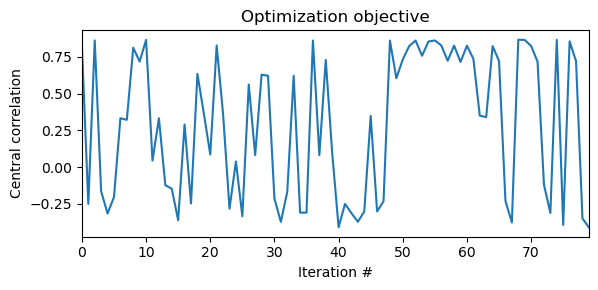

In [13]:
outputs.plot_optimization_objective();

### Visualize results

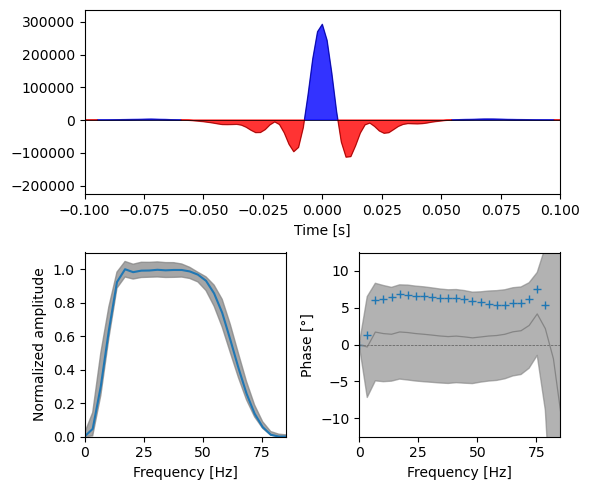

In [14]:
fig, axes = outputs.plot_wavelet(fmax=85, phi_max=15, figsize=(6,5))
axes[0].set_xlim((-0.1,0.1))
axes[2].set_ylim((-12.5,12.5))
fig.tight_layout()

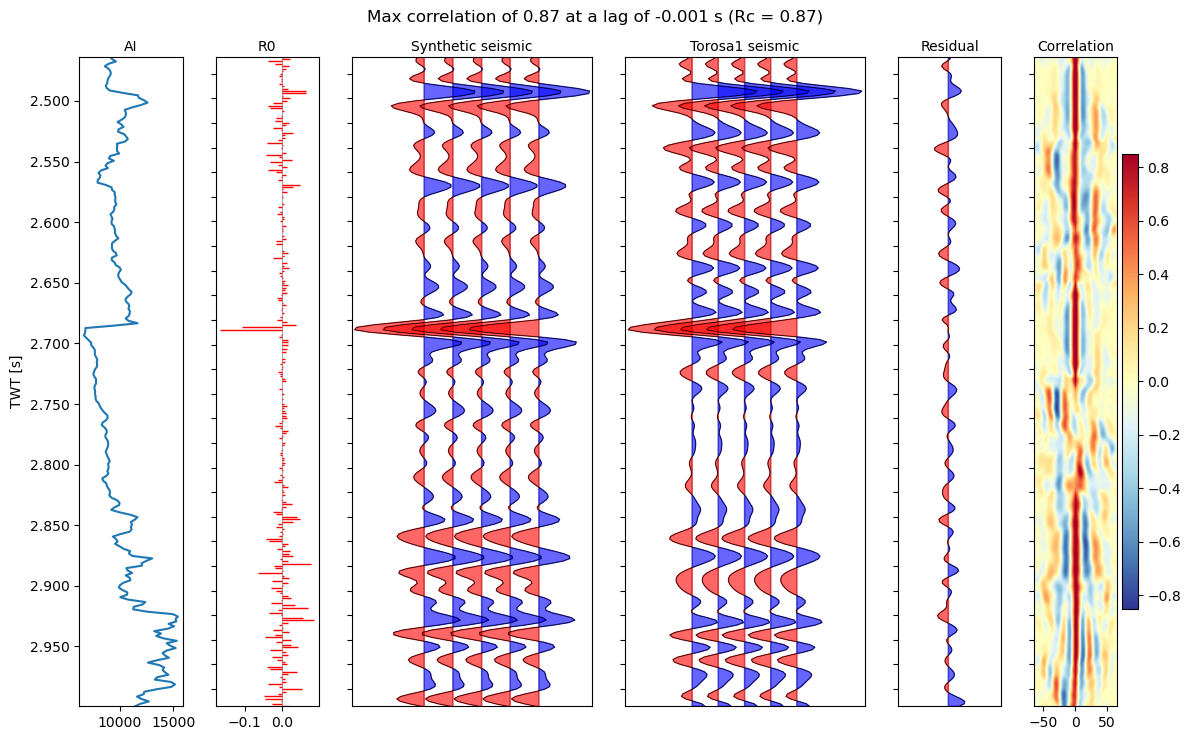

In [15]:
_scale = 120000
fig, axes = outputs.plot_tie_window(wiggle_scale=_scale, figsize=(12.,7.5))

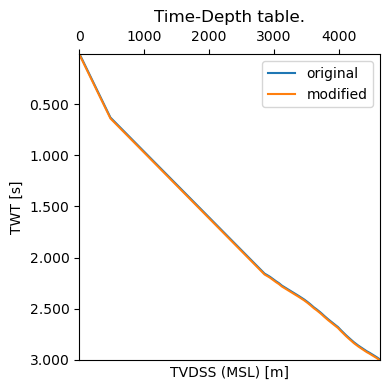

In [16]:
fig,ax = viz.plot_td_table(inputs.table, plot_params=dict(label='original'))
viz.plot_td_table(outputs.table,  plot_params=dict(label='modified'), fig_axes=(fig,ax))
ax.legend(loc='best')

#### Test automatic Stretch & Squeeze

In [17]:
s_and_s_params = dict(window_length=0.060, max_lag=0.010) # in seconds

outputs2 = autotie.stretch_and_squeeze(inputs,
                                       outputs,
                                       wavelet_extractor,
                                       modeler,
                                       wavelet_scaling_params,
                                       best_parameters,
                                       s_and_s_params)

upper
[3554.87390988 3618.6350957  3731.72046386 3483.14733342 3385.82729557
 3510.12896156 3572.06022665 3586.88659525 3543.73411909 3497.10667247
 3475.69064886 3471.22031856 3422.52863912 3453.09279009 3568.5329276
 4017.11467744 4502.53669658 4524.70544074 4724.52812735 4833.97473892
 4603.94978539 4328.28841317 4084.36437401 4097.99687608 4098.54838514
 4069.14868816 3949.75855644 3814.96545525 3941.49419691 4016.98580405
 3854.72904754 3834.0975155  4060.8851976  4113.13773073 4172.7992139
 4088.51726835 3791.92369225 3832.60603005 3778.40010309 3823.38773116
 3839.20060561 3573.46030954 3663.605986   3523.68752284 3407.55725766
 3522.71250921 3294.71588466 3200.91336798 3229.22806414 3228.23413327
 3176.29099112 3142.72643822 3417.1129559  3559.75720645 3562.47186385
 3654.24749433 3646.10081927 3678.18220338 3673.01054422 3676.98977921
 3722.473058   3629.27806184 3645.31743358 3619.36040936 3516.14985229
 3564.26982762 3567.4812973  3571.60020501 3554.83527473 3545.39070727
 3

  0%|          | 0/60 [00:00<?, ?it/s][WARNING 10-13 00:24:29] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[RangeParameter(name='scaler', parameter_type=FLOAT, range=[50000.0, 500000.0])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-13 00:24:29] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `experiment` to be of type typing.Union[ax.core.experiment.Experiment, NoneType]. Got Experiment(wavelet_absolute_scale_estimation) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-13 00:24:29] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `data` to be of type typing.Union[ax.core.data.Data, NoneType]. Got <ax.core.data.Data object at 0x7f45be63c8d0> (type: <class 'ax.core.data.Data'>).
[WARNING 10-13

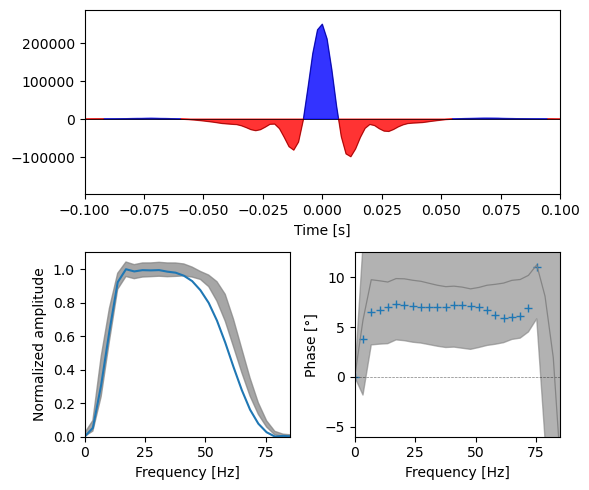

In [18]:
fig, axes = outputs2.plot_wavelet(fmax=85, phi_max=25, figsize=(6,5))
axes[0].set_xlim((-0.1,0.1))
axes[2].set_ylim((-6.,12.5))
fig.tight_layout()

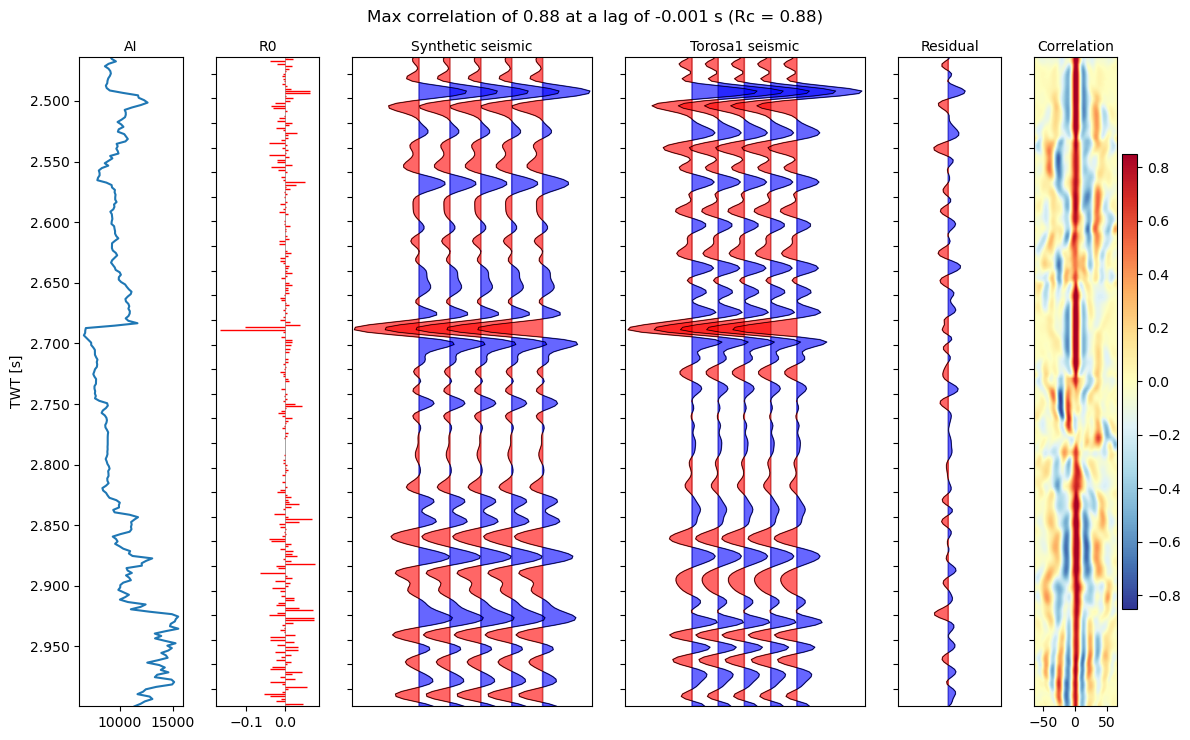

In [19]:
fig, axes = outputs2.plot_tie_window(wiggle_scale=_scale, figsize=(12.,7.5));
from matplotlib.ticker import MaxNLocator
axes[0].xaxis.set_major_locator(MaxNLocator(nbins=2))

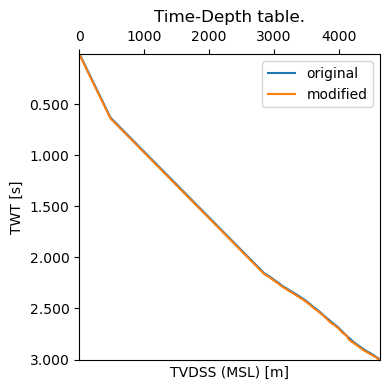

In [20]:
fig,ax = viz.plot_td_table(inputs.table, plot_params=dict(label='original'))
viz.plot_td_table(outputs2.table,  plot_params=dict(label='modified'), fig_axes=(fig,ax))
ax.legend(loc='best')

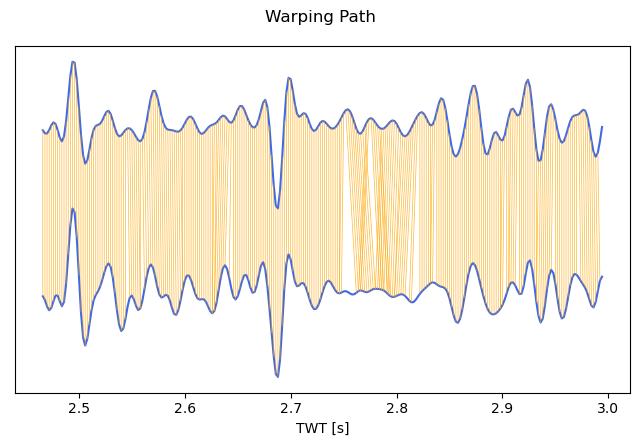

In [21]:
fig, ax = viz.plot_warping(outputs.synth_seismic, outputs.seismic, outputs2.dlags)